# Gender Analysis on CMU Movie Dataset

As feminist consciousness grows, gender differences in society have received much more attention and people start to wonder where gender differences occur. Movies are a significant player in people's lives. Thus we would like to examine whether gender differences exist in movies. We divide gender differences into gender stereotypes and gender inequalities and analyze how they affect the film itself and the film industry. We will first see whether gender stereotypes exist in movie plot summaries as their influence on movies themselves and figure out how they evolve over time. Then we will tap into the evolutions of gender inequalities from overall gender composition, social networks, and actor careers and make possible explanations in relation to gender stereotypes and social events. After this study, we can gain a deeper understanding of gender difference in films.

We want to answer these questions:
- Do gender stereotypes exist in movie plot summaries and how can we visualize them?
- How does the gender composition among the actors change over time?
- How does gender affect actors' careers in their opportunities and success?
- Is there a structural gender difference in the social networks of actors?

## Load the CMU movie dataset

We automatically extract dataset from this [website](http://www.cs.cmu.edu/~ark/personas/data/) and put all movie data at the folder `data/MovieSummaries/` and put plot summaries processed by CoreNLP at the folder `data/CoreNLP/`.

In [67]:
import os
import re
import math
import gzip
import spacy
import urllib
import string
import pickle
import tarfile
import requests
import itertools
import collections
import pandas as pd
import pandas as pd
import numpy as np
from collections import Counter
from utils.plot_processing import extract_word_frequency
import statsmodels.formula.api as smf
from wordcloud import WordCloud
from scipy import stats
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve

%matplotlib inline

In [68]:
cmu_path = "data/MovieSummaries/"
corenlp_path = "data/CoreNLP/"
summary_raw_path = corenlp_path + "corenlp_plot_summaries/"
summary_path = corenlp_path + "corenlp_plot_summaries_xml/"
movies_path = cmu_path + "movie.metadata.tsv"
characters_path = cmu_path + "character.metadata.tsv"
plot_path = cmu_path + "plot_summaries.txt"
gender_dict_path = "data/gender_dict.pkl"
gender_dict_with_time_path = "data/gender_dict_with_time.pkl"
gender_dict_with_genre_path = "data/gender_dict_with_genre.pkl"

In [145]:
if not os.path.exists(movies_path):
    movie_url = "http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz"
    tar_file = tarfile.open(fileobj=urllib.request.urlopen(movie_url), mode="r:gz")
    tar_file.extractall(path=movies_path)
    tar_file.close()

In [146]:
if not os.path.exists(corenlp_path):
    corenlp_url = "http://www.cs.cmu.edu/~ark/personas/data/corenlp_plot_summaries.tar"
    tar_file = tarfile.open(fileobj=urllib.request.urlopen(corenlp_url), mode="r|")
    tar_file.extractall(path=corenlp_path)

    os.mkdir(summary_path)
    for filename in os.listdir(summary_raw_path):
        f = os.path.join(summary_raw_path, filename)
        if os.path.isfile(f):
            with gzip.open(f, "rb") as f_in:
                gz_file = os.path.join(summary_path, filename)
                with open(gz_file[:-3], "wb") as f_out:
                    f_out.write(f_in.read())
    tar_file.close()

In [147]:
movies_column_names = [
    "wikipedia_id",
    "freebase_id",
    "name",
    "release_date",
    "box_office_revenue",
    "runtime",
    "languages",
    "countries",
    "genres",
]

characters_column_names = [
    "wikipedia_id",
    "freebase_id",
    "release_date",
    "character_name",
    "actor_dob",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age",
    "freebase_character_map",
    "freebase_character_id",
    "freebase_actor_id",
]

plot_column_names = ["wikipedia_id", "summary"]

movies = pd.read_csv(movies_path, sep="\t", header=None, names=movies_column_names)
characters = pd.read_csv(
    characters_path, sep="\t", header=None, names=characters_column_names
)
plots = pd.read_csv(plot_path, sep="\t", header=None, names=plot_column_names)

In [148]:
movies.head()

wikipedia_id freebase_id  \
0        975900   /m/03vyhn   
1       3196793   /m/08yl5d   
2      28463795  /m/0crgdbh   
3       9363483  /m/0285_cd   
4        261236   /m/01mrr1   

                                                name release_date  \
0                                     Ghosts of Mars   2001-08-24   
1  Getting Away with Murder: The JonBenét Ramsey ...   2000-02-16   
2                                        Brun bitter         1988   
3                                   White Of The Eye         1987   
4                                  A Woman in Flames         1983   

   box_office_revenue  runtime                           languages  \
0          14010832.0     98.0  {"/m/02h40lc": "English Language"}   
1                 NaN     95.0  {"/m/02h40lc": "English Language"}   
2                 NaN     83.0  {"/m/05f_3": "Norwegian Language"}   
3                 NaN    110.0  {"/m/02h40lc": "English Language"}   
4                 NaN    106.0   {"/m/04306rv": "German Language"}   

                                   countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   
2                     {"/m/05b4w": "Norway"}   
3             {"/m/07ssc": "United Kingdom"}   
4                    {"/m/0345h": "Germany"}   

                                              genres  
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...  
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...  
2  {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "D...  
3  {"/m/01jfsb": "Thriller", "/m/0glj9q": "Erotic...  
4                            {"/m/07s9rl0": "Drama"}

Attributes:

- `wikipedia_id`: Wikipedia movie ID
- `freebase_id`: Freebase movie ID
- `name`: Movie name
- `release_date`: Movie release date
- `box_office_revenue`: Movie box office revenue
- `runtime`: Movie runtime (in minutes)
- `languages`: Movie languages (Freebase ID:name tuples)
- `countries`: Movie countries (Freebase ID:name tuples)
- `genres`: Movie genres (Freebase ID:name tuples)

In [149]:
characters.head()

wikipedia_id freebase_id release_date              character_name  \
0        975900   /m/03vyhn   2001-08-24                    Akooshay   
1        975900   /m/03vyhn   2001-08-24  Lieutenant Melanie Ballard   
2        975900   /m/03vyhn   2001-08-24         Desolation Williams   
3        975900   /m/03vyhn   2001-08-24          Sgt Jericho Butler   
4        975900   /m/03vyhn   2001-08-24             Bashira Kincaid   

    actor_dob actor_gender  actor_height actor_ethnicity          actor_name  \
0  1958-08-26            F         1.620             NaN      Wanda De Jesus   
1  1974-08-15            F         1.780      /m/044038p  Natasha Henstridge   
2  1969-06-15            M         1.727         /m/0x67            Ice Cube   
3  1967-09-12            M         1.750             NaN       Jason Statham   
4  1977-09-25            F         1.650             NaN         Clea DuVall   

   actor_age freebase_character_map freebase_character_id freebase_actor_id  
0       42.0             /m/0bgchxw            /m/0bgcj3x        /m/03wcfv7  
1       27.0              /m/0jys3m            /m/0bgchn4         /m/0346l4  
2       32.0              /m/0jys3g            /m/0bgchn_        /m/01vw26l  
3       33.0             /m/02vchl6            /m/0bgchnq         /m/034hyc  
4       23.0             /m/02vbb3r            /m/0bgchp9         /m/01y9xg

Attributes:

- `wikipedia_id`: Wikipedia movie ID
- `freebase_id`: Freebase movie ID
- `release_date`: Movie release date
- `character_name`: Character name
- `actor_dob`: Actor date of birth
- `actor_gender`: actor_gender
- `actor_height`: Actor height (in meters)
- `actor_ethnicity`: Actor ethnicity (Freebase ID)
- `actor_name`: Actor name
- `actor_age`:actor_age
- `freebase_character_map`: Freebase character/actor map ID
- `freebase_character_id`: Freebase character ID
- `freebase_actor_id`: Freebase actor ID

In [150]:
plots.head()

wikipedia_id                                            summary
0      23890098  Shlykov, a hard-working taxi driver and Lyosha...
1      31186339  The nation of Panem consists of a wealthy Capi...
2      20663735  Poovalli Induchoodan  is sentenced for six yea...
3       2231378  The Lemon Drop Kid , a New York City swindler,...
4        595909  Seventh-day Adventist Church pastor Michael Ch...

Attributes:

Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.

The plot summaries are processed by CoreNLP pipeline (tagging, parsing, NER, and coref). The data are in the folder `data/CoreNLP/corenlp_plot_summaries_xml/*`. Each filename begins with the Wikipedia movie ID (which indexes into dataframe `movies`) and ends with the format `.xml`.

## Glance at the data and data preprocessing

### Missing values

First we glance at the data and see how many null values in the dataset.

#### Movies

In [151]:
print(
    "Percentage of NaN values in the movie dataset (total {} rows):".format(len(movies))
)
print(movies.isna().sum() / len(movies) * 100)

Percentage of NaN values in the movie dataset (total 81741 rows):
wikipedia_id           0.000000
freebase_id            0.000000
name                   0.000000
release_date           8.443743
box_office_revenue    89.722416
runtime               25.018045
languages              0.000000
countries              0.000000
genres                 0.000000
dtype: float64


Almost 90% of box office revenue data are missing, and box office revenue is NOT the aspect we want to study on gender analysis. Besides, about one fourth of movie runtime data are missing, and it is also NOT important for our gender analysis. Therefore, we will not use these features but will keep them.

Over 8% of the movie release dates are missing, which we need for gender analysis from a temporal perspective. So it is necessary to keep and properly process this feature. now we just choose to drop rows with null `release_date`.

In [152]:
movies = movies.dropna(subset=['release_date'])

print("{} movies left (81741 before).".format(len(movies)))
movies.head()

74839 movies left (81741 before).


wikipedia_id freebase_id  \
0        975900   /m/03vyhn   
1       3196793   /m/08yl5d   
2      28463795  /m/0crgdbh   
3       9363483  /m/0285_cd   
4        261236   /m/01mrr1   

                                                name release_date  \
0                                     Ghosts of Mars   2001-08-24   
1  Getting Away with Murder: The JonBenét Ramsey ...   2000-02-16   
2                                        Brun bitter         1988   
3                                   White Of The Eye         1987   
4                                  A Woman in Flames         1983   

   box_office_revenue  runtime                           languages  \
0          14010832.0     98.0  {"/m/02h40lc": "English Language"}   
1                 NaN     95.0  {"/m/02h40lc": "English Language"}   
2                 NaN     83.0  {"/m/05f_3": "Norwegian Language"}   
3                 NaN    110.0  {"/m/02h40lc": "English Language"}   
4                 NaN    106.0   {"/m/04306rv": "German Language"}   

                                   countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   
2                     {"/m/05b4w": "Norway"}   
3             {"/m/07ssc": "United Kingdom"}   
4                    {"/m/0345h": "Germany"}   

                                              genres  
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...  
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...  
2  {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "D...  
3  {"/m/01jfsb": "Thriller", "/m/0glj9q": "Erotic...  
4                            {"/m/07s9rl0": "Drama"}

#### Characters

In [153]:
print(
    "Percentage of NaN values in the character dataset (total {} rows):".format(
        len(characters)
    )
)
print(characters.isna().sum() / len(characters) * 100)

Percentage of NaN values in the character dataset (total 450669 rows):
wikipedia_id               0.000000
freebase_id                0.000000
release_date               2.217814
character_name            57.220488
actor_dob                 23.552763
actor_gender              10.120288
actor_height              65.645740
actor_ethnicity           76.466542
actor_name                 0.272484
actor_age                 35.084064
freebase_character_map     0.000000
freebase_character_id     57.218269
freebase_actor_id          0.180842
dtype: float64


We don't care about any id related to freebase, height, ethnicity, and dob, so we throw these attributes away.

However, more than half of the data in the column `character_name` are `NaN`s. This feature is quite important for gender analysis on plots. 10% of data in `actor_gender` and 35% of data in `actor_age` are also missing. Again we want temporal analysis but 2% of data in `release_date` are missing. We need to carefully handle these features. Here we just remove rows with null actor_gender or release date.

In [154]:
characters = characters.dropna(subset=['release_date'])

print("{} characters left (450669 before).".format(len(characters)))
characters.head()

440674 characters left (450669 before).


wikipedia_id freebase_id release_date              character_name  \
0        975900   /m/03vyhn   2001-08-24                    Akooshay   
1        975900   /m/03vyhn   2001-08-24  Lieutenant Melanie Ballard   
2        975900   /m/03vyhn   2001-08-24         Desolation Williams   
3        975900   /m/03vyhn   2001-08-24          Sgt Jericho Butler   
4        975900   /m/03vyhn   2001-08-24             Bashira Kincaid   

    actor_dob actor_gender  actor_height actor_ethnicity          actor_name  \
0  1958-08-26            F         1.620             NaN      Wanda De Jesus   
1  1974-08-15            F         1.780      /m/044038p  Natasha Henstridge   
2  1969-06-15            M         1.727         /m/0x67            Ice Cube   
3  1967-09-12            M         1.750             NaN       Jason Statham   
4  1977-09-25            F         1.650             NaN         Clea DuVall   

   actor_age freebase_character_map freebase_character_id freebase_actor_id  
0       42.0             /m/0bgchxw            /m/0bgcj3x        /m/03wcfv7  
1       27.0              /m/0jys3m            /m/0bgchn4         /m/0346l4  
2       32.0              /m/0jys3g            /m/0bgchn_        /m/01vw26l  
3       33.0             /m/02vchl6            /m/0bgchnq         /m/034hyc  
4       23.0             /m/02vbb3r            /m/0bgchp9         /m/01y9xg

#### Plot summaries

In [155]:
print(
    "Percentage of NaN values in the plot dataset (total {} rows):".format(len(plots))
)
print(plots[(plots.isna()) | (plots == "")].sum() / len(plots) * 100)

Percentage of NaN values in the plot dataset (total 42303 rows):
wikipedia_id    0.0
summary         0.0
dtype: object


In [156]:
plots.wikipedia_id.duplicated().sum()

0

Great! We don't have empty plot summaries in the plot dataframe. We have 81741 movies (ignore possible duplicated movies), but only 42303 of them have plot summaries. From above we can see there's no duplicated movies in the plot dataset. Therefore, we can focus on these movies.for gender analysis on plot summaries.

### Release date

The feature `release_date` is important because we need temporal analysis on gender. However, some values are missing and the format is not unified:

In [157]:
print("Movie dataset:")
print(movies.release_date)
print("==========================")
print("Character dataset:")
print(characters.release_date)

Movie dataset:
0        2001-08-24
1        2000-02-16
2              1988
3              1987
4              1983
            ...    
81736    2011-03-19
81737    2011-01-21
81738    1972-09-22
81739    1992-05-21
81740          2002
Name: release_date, Length: 74839, dtype: object
Character dataset:
0         2001-08-24
1         2001-08-24
2         2001-08-24
3         2001-08-24
4         2001-08-24
             ...    
450664    1992-05-21
450665    1992-05-21
450666          1957
450667          1957
450668          1957
Name: release_date, Length: 440674, dtype: object


We just focus on granularity of year, so we can reformat our dataset.

In [158]:
def extract_year(x):
    return str(x)[:4]


movies.release_date = movies.release_date.apply(extract_year)
characters.release_date = characters.release_date.apply(extract_year)

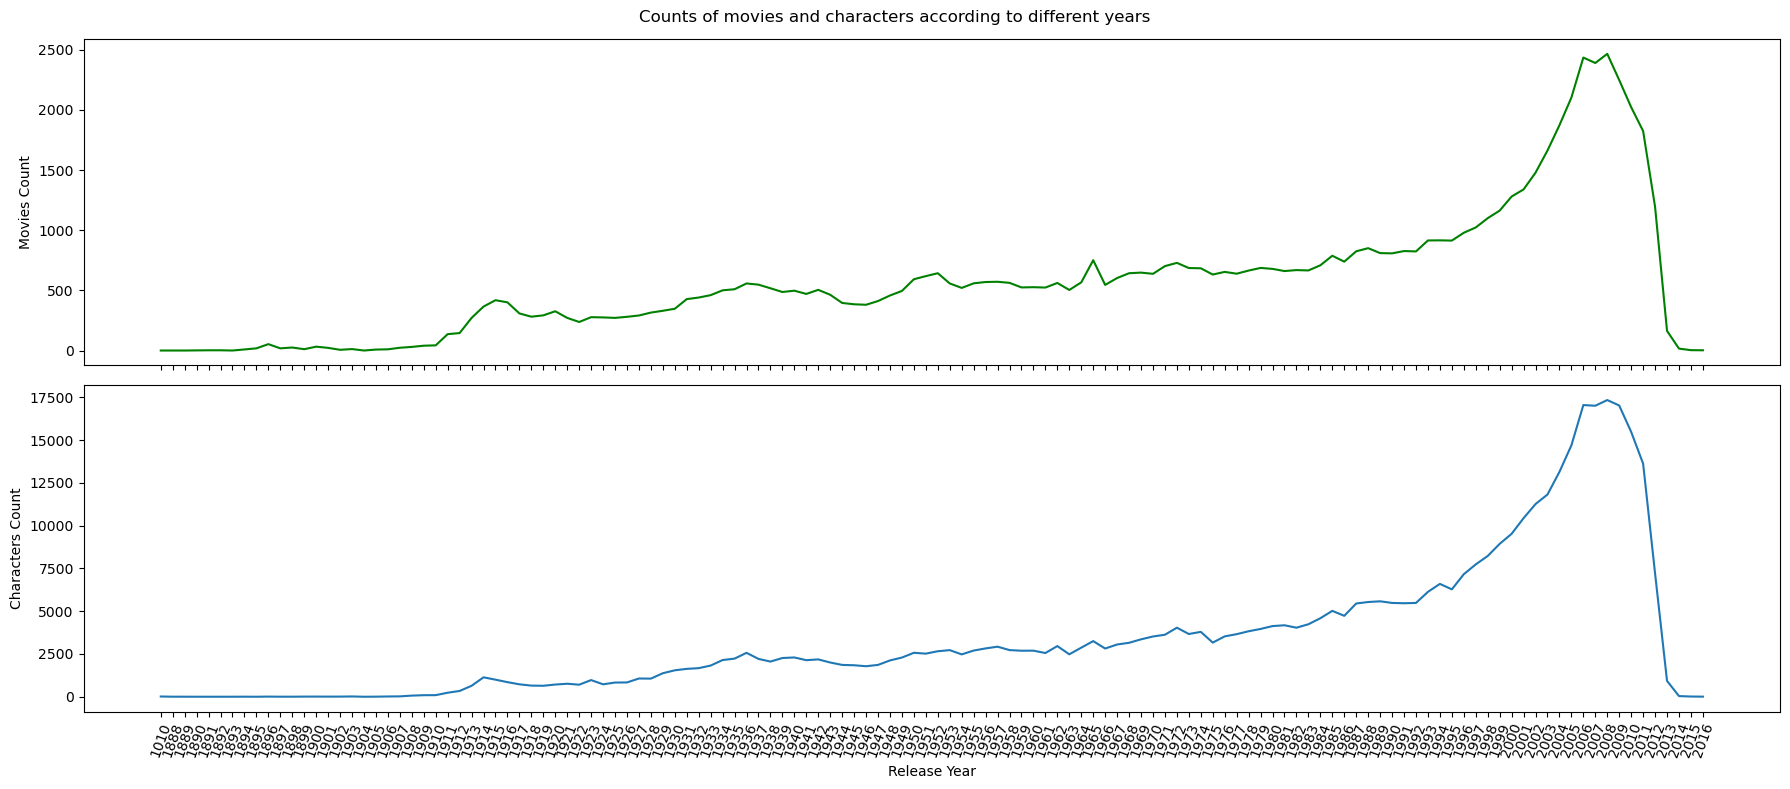

In [17]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(18, 8))
fig.suptitle("Counts of movies and characters according to different years")

ax = sns.lineplot(
    data=movies.release_date.value_counts().sort_index(), ax=axes[0], color="g"
)
ax.set_xticks(np.unique(movies.release_date))
ax.set_xticklabels(np.unique(movies.release_date), rotation=70)

ax = sns.lineplot(data=characters.release_date.value_counts().sort_index(), ax=axes[1])
ax.set_xticks(np.unique(movies.release_date))
ax.set_xticklabels(np.unique(movies.release_date), rotation=70)

axes[0].set(xlabel="Release Year", ylabel="Movies Count")
axes[1].set(xlabel="Release Year", ylabel="Characters Count")
plt.tight_layout()
plt.show()

We can see there's one outlier `1010`. We found that the movie is [*Hunting Season*](https://en.wikipedia.org/wiki/Hunting_Season_(2010_film)) which was released in 2010. So it is wrongly reported and we assume the year should be `2010`. We will fix this error now.

Besides, these two distributions are skewed, and we need to carefully sample the dataset when doing temporal analysis. We will handle it in the future.

In [18]:
movies[movies.release_date == "1010"]

wikipedia_id freebase_id            name release_date  \
62836      29666067  /m/0fphzrf  Hunting Season         1010   

       box_office_revenue  runtime  \
62836          12160978.0    140.0   

                                               languages  \
62836  {"/m/02hwyss": "Turkish Language", "/m/02h40lc...   

                     countries  \
62836  {"/m/01znc_": "Turkey"}   

                                                  genres  
62836  {"/m/0lsxr": "Crime Fiction", "/m/02n4kr": "My...

In [19]:
movies.release_date = movies.release_date.apply(lambda x: "2010" if x == "1010" else x)
characters.release_date = characters.release_date.apply(
    lambda x: "2010" if x == "1010" else x
)

### Language, countries, and genres

They are encoded string of dictionaries whose keys are freebase ids. We will only keep the values and put the values in a list. We will also remove "Language" from elements in column `languages`.

In [20]:
movies[["languages", "countries", "genres"]]

languages  \
0      {"/m/02h40lc": "English Language"}   
1      {"/m/02h40lc": "English Language"}   
2      {"/m/05f_3": "Norwegian Language"}   
3      {"/m/02h40lc": "English Language"}   
4       {"/m/04306rv": "German Language"}   
...                                   ...   
81736  {"/m/02h40lc": "English Language"}   
81737  {"/m/02h40lc": "English Language"}   
81738  {"/m/02h40lc": "English Language"}   
81739   {"/m/03_9r": "Japanese Language"}   
81740  {"/m/02h40lc": "English Language"}   

                                               countries  \
0              {"/m/09c7w0": "United States of America"}   
1              {"/m/09c7w0": "United States of America"}   
2                                 {"/m/05b4w": "Norway"}   
3                         {"/m/07ssc": "United Kingdom"}   
4                                {"/m/0345h": "Germany"}   
...                                                  ...   
81736          {"/m/09c7w0": "United States of America"}   
81737  {"/m/03rt9": "Ireland", "/m/07ssc": "United Ki...   
81738          {"/m/09c7w0": "United States of America"}   
81739                              {"/m/03_3d": "Japan"}   
81740                            {"/m/0d060g": "Canada"}   

                                                  genres  
0      {"/m/01jfsb": "Thriller", "/m/06n90": "Science...  
1      {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...  
2      {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "D...  
3      {"/m/01jfsb": "Thriller", "/m/0glj9q": "Erotic...  
4                                {"/m/07s9rl0": "Drama"}  
...                                                  ...  
81736                            {"/m/07s9rl0": "Drama"}  
81737  {"/m/03bxz7": "Biographical film", "/m/07s9rl0...  
81738       {"/m/06nbt": "Satire", "/m/01z4y": "Comedy"}  
81739  {"/m/06n90": "Science Fiction", "/m/0gw5n2f": ...  
81740  {"/m/01jfsb": "Thriller", "/m/03npn": "Horror"...  

[74839 rows x 3 columns]

In [21]:
get_dict_keys = (
    lambda x: np.nan
    if x == {}
    else [re.sub(r"\x20[Ll]anguage", "", w) for w in re.findall(r'"(.*?)"', x)[1::2]]
)
movies.countries = movies.countries.apply(get_dict_keys)
movies.languages = movies.languages.apply(get_dict_keys)
movies.genres = movies.genres.apply(get_dict_keys)

In [22]:
movies.head()

wikipedia_id freebase_id  \
0        975900   /m/03vyhn   
1       3196793   /m/08yl5d   
2      28463795  /m/0crgdbh   
3       9363483  /m/0285_cd   
4        261236   /m/01mrr1   

                                                name release_date  \
0                                     Ghosts of Mars         2001   
1  Getting Away with Murder: The JonBenét Ramsey ...         2000   
2                                        Brun bitter         1988   
3                                   White Of The Eye         1987   
4                                  A Woman in Flames         1983   

   box_office_revenue  runtime    languages                   countries  \
0          14010832.0     98.0    [English]  [United States of America]   
1                 NaN     95.0    [English]  [United States of America]   
2                 NaN     83.0  [Norwegian]                    [Norway]   
3                 NaN    110.0    [English]            [United Kingdom]   
4                 NaN    106.0     [German]                   [Germany]   

                                              genres  
0  [Thriller, Science Fiction, Horror, Adventure,...  
1   [Mystery, Biographical film, Drama, Crime Drama]  
2                             [Crime Fiction, Drama]  
3  [Thriller, Erotic thriller, Psychological thri...  
4                                            [Drama]

In [23]:
languages_count = pd.Series(
    [x for item in movies.languages for x in item]
).value_counts()
print(
    "There are {} languages, but {} of them only have less than 1000 films.".format(
        len(languages_count), (languages_count < 1000).sum()
    )
)
print(languages_count)

There are 202 languages, but 190 of them only have less than 1000 films.
English                                 39680
Spanish                                  3532
Hindi                                    3432
French                                   3323
Silent film                              3079
                                        ...  
Southwestern Mandarin                       1
Australian Aboriginal Pidgin English        1
Tok Pisin                                   1
Pawnee                                      1
Kuna                                        1
Length: 202, dtype: int64


#### Language distribution

We first see the distribution of languages.

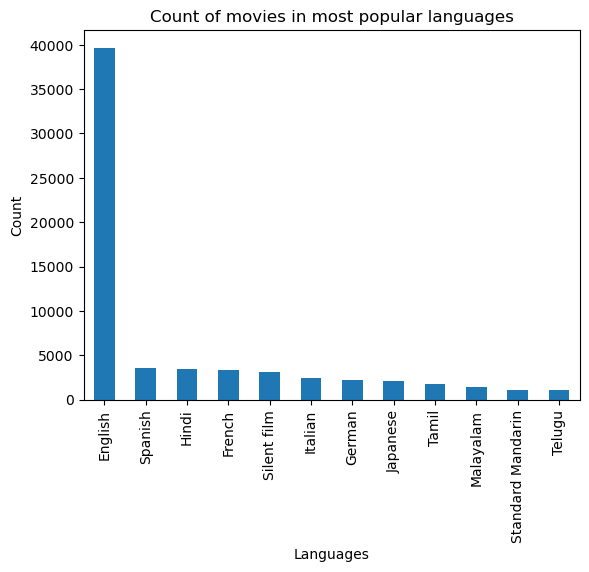

In [24]:
ax = languages_count[languages_count >= 1000].plot(kind="bar")
ax.set(xlabel="Languages", ylabel="Count")
ax.set_title("Count of movies in most popular languages")
plt.show()

The distribution is highly skewed. If we want to do gender analysis on movies from different languages, we may only choose a subset of them that have enough movies.

There are silent films in the dataset and we may drop them if we want to do this kind of analysis. Now we choose to keep them.

In [25]:
countries_count = pd.Series(
    [x for item in movies.countries for x in item]
).value_counts()
print(
    "There are {} countries/regions, but {} of them only have less than 1000 films.".format(
        len(countries_count), (countries_count < 1000).sum()
    )
)
print(countries_count)

There are 146 countries/regions, but 134 of them only have less than 1000 films.
United States of America    33197
India                        7764
United Kingdom               7452
France                       4199
Italy                        3017
                            ...  
Republic of China               1
Macau                           1
Palestinian Territories         1
German                          1
Ukranian SSR                    1
Length: 146, dtype: int64


#### Country distribution

Then let's see the country distribution.

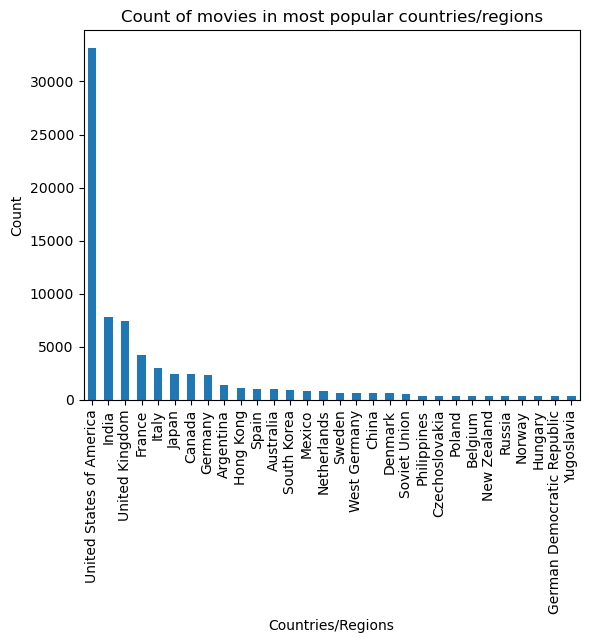

In [26]:
ax = countries_count.iloc[:30].plot(kind="bar")
ax.set(xlabel="Countries/Regions", ylabel="Count")
ax.set_title("Count of movies in most popular countries/regions")
plt.show()

We can see the distribution is also highly skewed. If we want to do gender analysis on movies from different countries/regions, we may only choose a subset of them that have enough movies.

Besides, country/region names are changing (e.g. Germany, West Germany, German Democratic Republic; Soviet Union, Russia). We are still thinking about whether to retain this feature.

#### Genre distribution

Finally, the genre distribution.

In [29]:
genres_count = Counter(movies.genres.sum())

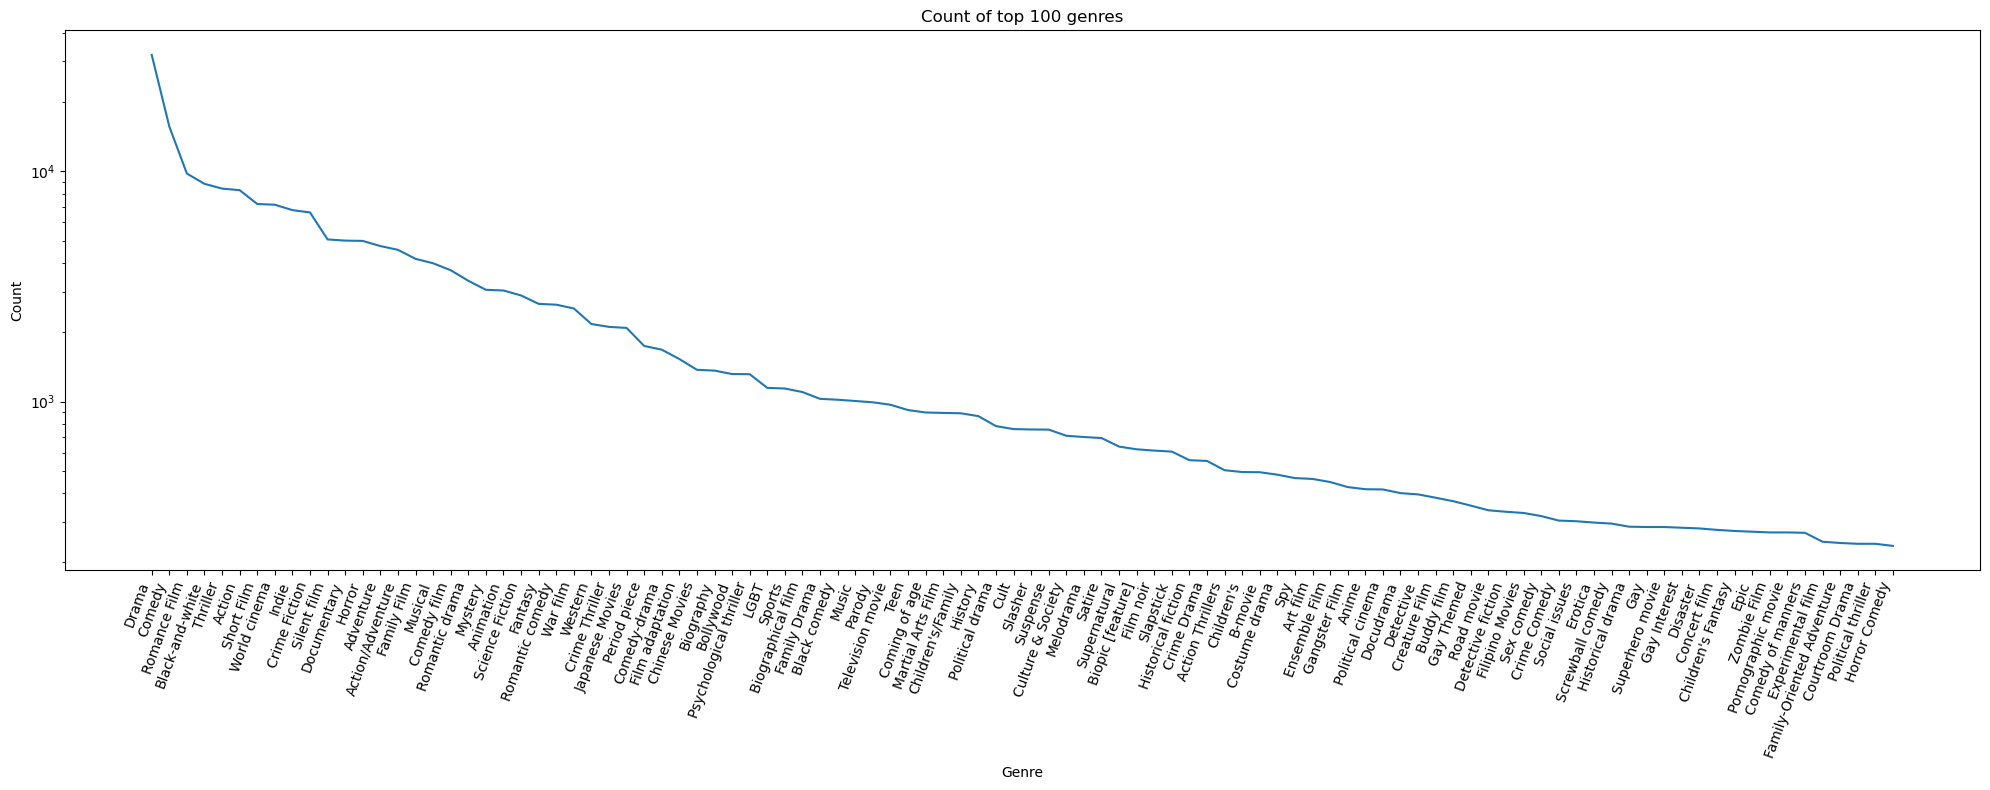

In [62]:
genres_distribution = pd.DataFrame.from_dict(genres_count, orient="index", columns=["count"]).sort_values(by="count", ascending=False)
ax = genres_distribution.iloc[:100].plot(xticks = np.arange(100), rot=70, logy=True, legend=False, figsize=(20, 8))
plt.xticks(ha="right")
plt.ylabel("Count")
plt.xlabel("Genre")
plt.title("Count of top 100 genres")
plt.tight_layout()
plt.show()

There are too many genres in all, so we only count the top 100 genres. Even though we cut the first 100 genres, it is long-tailed.

## Gender stereotype analysis on movie plot summaries

Now we want to know whether gender stereotypes exist in movie plot summaries. Gender stereotypes are the wording difference between men and women. Some words are related with genders, causing the difference, like actor and actress, waiter and waitress, brother and sister, etc. We think the existence of these words just shows the bias, so we won't study that. Instead, we want to focus on the words which should be gender-neutral but actually biased. For example, the doctor and the nurse.

How do we find the words describing men and women in the movie plots? We consider relevant words around male characters and female characters. We implement this by searching plot summaries containing character names in the `character` dataframe.

Besides, how do we exclude the words that are not gender-neutral and not meaningful? We assume that most verbs and adjectives are gender-neutral and meaningful, while nouns are not. So we identify relevant words as first or last two words of verb or adjective from the character name within one sentence. We extract relevant words around these names by gender and count log frequency of words related to different genders. Finally we analyze top 20 frequent words for different genders.

### Preprocessing

First we join plot summaries to movies dataset.

In [39]:
movies_plots = pd.merge(movies, plots, on="wikipedia_id", how="inner")[
    ["wikipedia_id", "release_date", "languages", "countries", "genres", "summary"]
]
movies_plots.head()

wikipedia_id release_date  languages                   countries  \
0        975900         2001  [English]  [United States of America]   
1       9363483         1987  [English]            [United Kingdom]   
2        261236         1983   [German]                   [Germany]   
3      18998739         2002  [English]              [South Africa]   
4       6631279         1997  [English]  [United States of America]   

                                              genres  \
0  [Thriller, Science Fiction, Horror, Adventure,...   
1  [Thriller, Erotic thriller, Psychological thri...   
2                                            [Drama]   
3    [Family Film, Fantasy, Adventure, World cinema]   
4  [Romantic comedy, Ensemble Film, Comedy-drama,...   

                                             summary  
0  Set in the second half of the 22nd century, th...  
1  A series of murders of rich young women throug...  
2  Eva, an upper class housewife, becomes frustra...  
3  Every hundred years, the evil Morgana  returns...  
4  Adam, a San Francisco-based artist who works a...

Then we filter movies with plots containing character names in characters dataframe and add these character names in the movies dataframe.

In [40]:
characters_filtered = characters.dropna(subset=["character_name", "actor_gender"])
characters_filtered.head()

wikipedia_id freebase_id release_date              character_name  \
0        975900   /m/03vyhn         2001                    Akooshay   
1        975900   /m/03vyhn         2001  Lieutenant Melanie Ballard   
2        975900   /m/03vyhn         2001         Desolation Williams   
3        975900   /m/03vyhn         2001          Sgt Jericho Butler   
4        975900   /m/03vyhn         2001             Bashira Kincaid   

    actor_dob actor_gender  actor_height actor_ethnicity          actor_name  \
0  1958-08-26            F         1.620             NaN      Wanda De Jesus   
1  1974-08-15            F         1.780      /m/044038p  Natasha Henstridge   
2  1969-06-15            M         1.727         /m/0x67            Ice Cube   
3  1967-09-12            M         1.750             NaN       Jason Statham   
4  1977-09-25            F         1.650             NaN         Clea DuVall   

   actor_age freebase_character_map freebase_character_id freebase_actor_id  
0       42.0             /m/0bgchxw            /m/0bgcj3x        /m/03wcfv7  
1       27.0              /m/0jys3m            /m/0bgchn4         /m/0346l4  
2       32.0              /m/0jys3g            /m/0bgchn_        /m/01vw26l  
3       33.0             /m/02vchl6            /m/0bgchnq         /m/034hyc  
4       23.0             /m/02vbb3r            /m/0bgchp9         /m/01y9xg

In [41]:
temp_df = movies_plots[movies_plots.wikipedia_id.isin(characters_filtered.wikipedia_id)]

In [42]:
index = []
name_gender = []
count_gender = {"M": 0, "F": 0}
for i in range(len(temp_df)):
    temp_name_gender = {}
    flag = 0
    filtered = characters_filtered[
        characters_filtered.wikipedia_id == temp_df.iloc[i].wikipedia_id
    ]
    for word, gender in zip(
        filtered.character_name.apply(str.lower), filtered.actor_gender
    ):
        if (
            word in temp_df.iloc[i].summary.lower()
        ):  # only consider full match. i.e. full character name matches with the plot summary.
            if (
                flag == 0
            ):  # if there's one full match in the plot summary, we keep this movie.
                index.append(i)
                flag = 1
            temp_name_gender[word] = gender
            count_gender[gender] += 1
    if flag == 1:
        name_gender.append(temp_name_gender)

assert len(name_gender) == len(index)

In [43]:
movies_plots_filtered = temp_df.iloc[index].copy()
movies_plots_filtered.loc[:, "character_names"] = name_gender
movies_plots_filtered = movies_plots_filtered.reset_index(drop=True)
movies_plots_filtered.head()

wikipedia_id release_date  languages                   countries  \
0        975900         2001  [English]  [United States of America]   
1      18998739         2002  [English]              [South Africa]   
2       6631279         1997  [English]  [United States of America]   
3        171005         1989  [English]            [United Kingdom]   
4         77856         1964  [English]  [United States of America]   

                                              genres  \
0  [Thriller, Science Fiction, Horror, Adventure,...   
1    [Family Film, Fantasy, Adventure, World cinema]   
2  [Romantic comedy, Ensemble Film, Comedy-drama,...   
3  [Costume drama, War film, Epic, Period piece, ...   
4  [Children's/Family, Musical, Fantasy, Comedy, ...   

                                             summary  \
0  Set in the second half of the 22nd century, th...   
1  Every hundred years, the evil Morgana  returns...   
2  Adam, a San Francisco-based artist who works a...   
3  {{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...   
4  The film opens with Mary Poppins  perched in a...   

                                     character_names  
0                       {'desolation williams': 'M'}  
1                                   {'morgana': 'F'}  
2                      {'rebecca': 'F', 'nina': 'F'}  
3                                   {'henry v': 'M'}  
4  {'george banks': 'M', 'bert': 'M', 'mary poppi...

In [44]:
print(
    "There are only {} movies left and with {} male characters and {} female characters.".format(
        len(movies_plots_filtered), count_gender["M"], count_gender["F"]
    )
)

There are only 16403 movies left and with 30077 male characters and 15701 female characters.


Now we extract nouns, verbs, and adjectives around male and female character names and put these words in `male_dict` and `female_dict` to calculate the frequency of words. We also count the word frequency of different types of words (noun, verb, adjective).

In [45]:
# for each gender, compute word frequency dictionary on all words/nouns/verbs/adjectives.
gender_dict = {
    "M": {"all": {}, "noun": {}, "verb": {}, "adj": {}},
    "F": {"all": {}, "noun": {}, "verb": {}, "adj": {}},
}

# keep these POSs and map POS to verbs/nouns/adjectives
pos_mapping = {
    "JJ": "adj", "JJR": "adj", "JJS": "adj",                                                    # adjectives
    "NN": "noun", "NNS": "noun", "NNP": "noun", "NNPS": "noun",                                 # nouns
    "VB": "verb", "VBD": "verb", "VBG": "verb", "VBN": "verb", "VBP": "verb", "VBZ": "verb",    # verbs
}

window_size = 2  # search two words of {n., adj., v.} before first name and after last name if possible.

It takes too long time to generate the word frequency. We need to store it!

In [46]:
if not os.path.exists(gender_dict_path):
    # compute the word frequency of different word types
    gender_dict = extract_word_frequency(movies_plots_filtered, gender_dict, pos_mapping, summary_path, window_size=window_size)

    # create a binary pickle file 
    with open(gender_dict_path, "wb") as f:
        # write the python object (dict) to pickle file
        pickle.dump(gender_dict, f)

else:
    with open(gender_dict_path, "rb") as f:
        gender_dict = pickle.load(f)

There are so many stopwords like "be", "have", etc. We want to remove them.

In [47]:
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
spacy_stopwords.add("s")

In [48]:
for gender, inner_dict in gender_dict.items():
    for word_type, freq_dict in inner_dict.items():
        for stopword in spacy_stopwords:
                freq_dict.pop(stopword.lower(), None)

### Overall analysis

Now we want to know whether gender stereotypes exist in movie plot summaries. We define gender stereotypes as the distribution difference of the words describing male and female characters in the movie plot summaries. We consider relevant words around male characters and female characters. We implement this by searching plot summaries containing character names in the `character` dataframe. Then we identify relevant words as first or last two words of noun, verb, or adjective from the character name within one sentence. We extract relevant words around these names by gender and count log frequency of words related to different genders. Finally we analyze top 20 frequent words for different genders.

#### Qualitative

We first analyze the overall distribution of relevant words of male and female characters. Then we compare log frequencies of different POS of the words (noun, verb, adjective) between men and women.

In [34]:
diff_dict = {}
male_dict = {}
female_dict = {}

for idx, word_type in enumerate(["all", "noun", "verb", "adj"]):
    male_words = pd.DataFrame.from_dict(
        gender_dict["M"][word_type], orient="index", columns=["count"]
    ).sort_values(by=["count"])
    male_dict[word_type] = male_words

    female_words = pd.DataFrame.from_dict(
        gender_dict["F"][word_type], orient="index", columns=["count"]
    ).sort_values(by=["count"])
    female_dict[word_type] = female_words

    diff_words = pd.concat([male_words, female_words], axis=1).dropna()
    diff_words.columns = ["count_m", "count_f"]
    diff_words.fillna(0, inplace=True)
    diff_words["freq_m"] = diff_words["count_m"] / diff_words["count_m"].sum()
    diff_words["freq_f"] = diff_words["count_f"] / diff_words["count_f"].sum()
    diff_words["freq_diff"] = diff_words.freq_m - diff_words.freq_f
    diff_dict[word_type] = diff_words

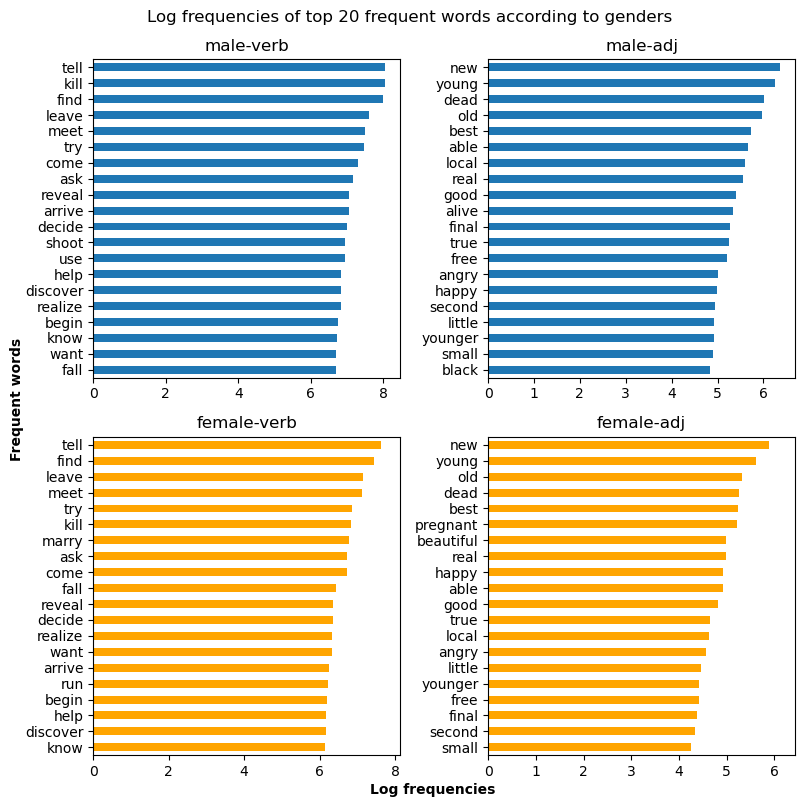

In [172]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()
fig.suptitle(
    "Log frequencies of top 20 frequent words according to genders"
)

for idx, word_type in enumerate(["verb", "adj"]):

    ax = np.log(male_dict[word_type]["count"][-20:]).plot.barh(
        ax=axes[idx], legend=False, title="male-{}".format(word_type)
    )
    ax = np.log(female_dict[word_type]["count"][-20:]).plot.barh(
        ax=axes[idx + 2],
        color="orange",
        legend=False,
        title="female-{}".format(word_type),
    )
    ax.set_xlim(0, max(np.log(male_dict[word_type]["count"][-20:]).max(), np.log(male_dict[word_type]["count"][-20:]).max())*1.01)

fig.text(0.45, 0, "Log frequencies", weight="bold")
fig.text(0, 0.42, "Frequent words", rotation=90, weight="bold")
plt.tight_layout()
plt.show()

We can roughly see that males are more related to the words "kill" and "shoot" while females are associated with the words "marry". However, these figures are not obvious, because there are too many words that are common to both men and women with very high frequency. 

Therefore, we turn to study the (absolute) frequency difference, i.e, $\displaystyle\text{score}_{\text{word}_i} = \frac{count(\text{word}_i \in \{\text{male words}\})}{count(\{\text{male words}\})} - \frac{count(\text{word}_i \in \{\text{female words}\})}{count(\{\text{female words}\})}$.

The words with large positive values means that the words are highly biased towards male characters, while those with large negative values indicates the words are more related to females than males.

Then we sort the words with the most positive (male bias) and the most negative (female bias) differences.

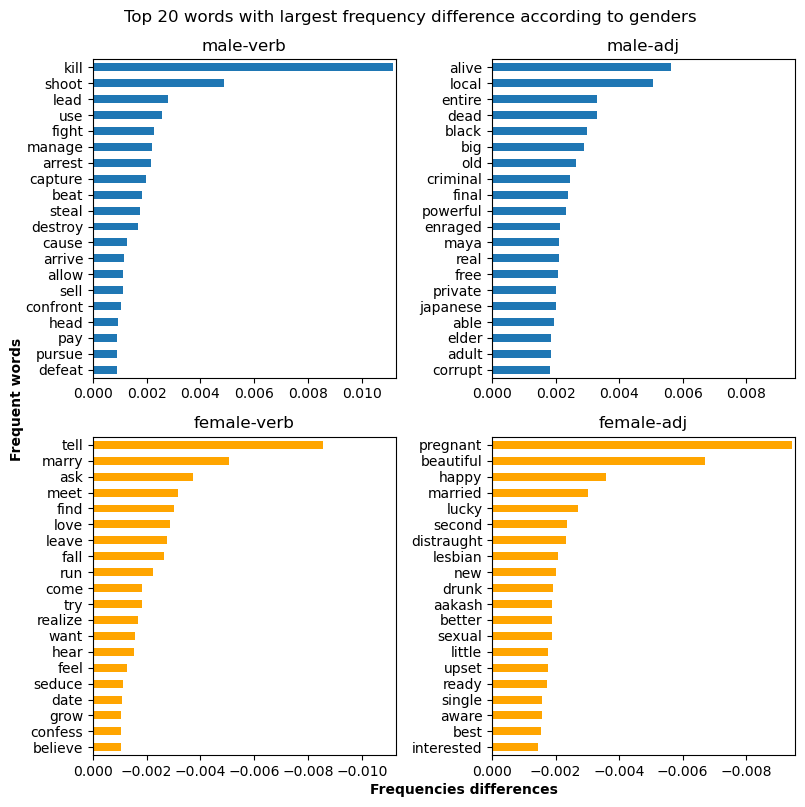

In [173]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()
fig.suptitle(
    "Top 20 words with largest frequency difference according to genders"
)

for idx, word_type in enumerate(["verb", "adj"]):
    male_words = diff_dict[word_type].freq_diff.sort_values()[-20:]
    female_words = diff_dict[word_type].freq_diff.sort_values(ascending=False)[-20:]
    ax1 = male_words.plot.barh(
        ax=axes[idx], legend=False, title="male-{}".format(word_type)
    )
    ax1.set_xlim(0.000, max(abs(male_words).max(), abs(female_words).max())*1.01)
    ax2 = female_words.plot.barh(
        ax=axes[idx + 2],
        color="orange",
        legend=False,
        title="female-{}".format(word_type),
    )
    ax2.set_xlim(0.000, -max(abs(male_words).max(), abs(female_words).max())*1.01)

fig.text(0.45, 0, "Frequencies differences", weight="bold")
fig.text(0, 0.42, "Frequent words", rotation=90, weight="bold")
plt.tight_layout()
plt.show()

**Analysis**:

We can find that men and women have more distinct word preferences. For the verbs, males are associated with crime (kill, shoot, fight, arrest, destroy, steal, beat, etc.) and power (lead, manage), but females are depicted with the word "marry", "love", and "seduce".

For the adjectives, we can see a similar trend. Crime words co-occur with males (dead, criminal), together with power (powerful) and politics (corrupt). But women are tied with sex (sexual), marriage (married), reproduction (pregnant), and appearance (beautiful).

#### Quantitative

Beyonds qualitative analysis, we also have some quantitative measurements. First, we wonder whether there is a significant difference of word frequency distributions between men and women. We adopt the chi-sqaure test. A chi-square test is a statistical test used to compare the distribution of a categorical variable in two or more groups. It is based on the chi-square statistic, which is a measure of the difference between the observed frequencies of a categorical variable in a sample and the frequencies that would be expected if the two groups were independent.

To perform the chi-square test, we need the counts of male and female relevant word distributions, and we should scale the sum of them to be the same. So we first calculate the absolute frequencies of two distributions and then multiply the number of male relevant words and female relevant words. We will get two p-values for each word type.

In [212]:
# compute the chi-square p-value

print(f'verb (scale to the count of relevant words of males):   {stats.chisquare(diff_dict["verb"].sort_index().count_m, diff_dict["verb"].sort_index().count_m.sum()*diff_dict["verb"].sort_index().freq_f)}')
print(f'verb (scale to the count of relevant words of females): {stats.chisquare(diff_dict["verb"].sort_index().count_f, diff_dict["verb"].sort_index().count_f.sum()*diff_dict["verb"].sort_index().freq_m)}')
print(f'adj (scale to the count of relevant words of males):    {stats.chisquare(diff_dict["adj"].sort_index().count_m, diff_dict["adj"].sort_index().count_m.sum()*diff_dict["adj"].sort_index().freq_f)}')
print(f'adj (scale to the count of relevant words of females):  {stats.chisquare(diff_dict["adj"].sort_index().count_f, diff_dict["adj"].sort_index().count_f.sum()*diff_dict["adj"].sort_index().freq_m)}')

verb (scale to the count of relevant words of males):   Power_divergenceResult(statistic=10043.382514619308, pvalue=0.0)
verb (scale to the count of relevant words of females): Power_divergenceResult(statistic=4660.925534367175, pvalue=4.83837663678155e-309)
adj (scale to the count of relevant words of males):    Power_divergenceResult(statistic=4131.370372833231, pvalue=0.0)
adj (scale to the count of relevant words of females):  Power_divergenceResult(statistic=2913.6626047304153, pvalue=9.322588446103035e-141)


We could see the p-value is extremely close to 0 (or 0), so there's a significant difference in the two distributions!

We use KL divergence for measuring how different the two distributions are. The Kullback-Leibler divergence (also known as KL divergence or relative entropy) is a measure of the difference between two probability distributions. It is used to quantify the amount of information lost when approximating a distribution with another distribution. Mathematically, it is defined as:

$$
\text{KL}(P\|Q) = \sum_i P(i) * \log(\frac{P(i)}{Q(i)})
$$

where P and Q are the two probability distributions being compared, and the sum is taken over all possible values of the random variable.

In [213]:
# KL divergence

def KL(P, Q):
    """ Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0. 
    """
    eps = 0.00001

    # You may want to instead make copies to avoid changing the np arrays.
    P = P + eps
    Q = Q + eps

    divergence = np.sum(P * np.log(P / Q))
    return divergence

In [214]:
print(f'KL divergence for verb: {KL(diff_dict["verb"].sort_index().freq_m, diff_dict["verb"].sort_index().freq_f)}')
print(f'KL divergence for adj:  {KL(diff_dict["adj"].sort_index().freq_m, diff_dict["adj"].sort_index().freq_f)}')

KL divergence for verb: 0.07284664302233439
KL divergence for adj:  0.1623056868051693


### Evolution with Time

Next, we want to discover how the gender stereotype varies across time. We will still use the qualitative and quantative analysis. We group the movies by the release date and cut by decades.

In [215]:
tmp = movies_plots_filtered.copy()
tmp = tmp[(tmp.release_date>='1913')&(tmp.release_date<='2013')]
tmp["release_date_cat"] = pd.cut(tmp.release_date.apply(int), bins=10)

if not os.path.exists(gender_dict_with_time_path):
    gender_dict_with_time = {}
    for time_span, group in tmp.groupby("release_date_cat"):
        gen_dict = {
            "M": {"all": {}, "noun": {}, "verb": {}, "adj": {}},
            "F": {"all": {}, "noun": {}, "verb": {}, "adj": {}},
        }
        # compute the word frequency every ten years
        gender_dict_with_time[time_span] = extract_word_frequency(group, gen_dict, pos_mapping, summary_path, window_size=window_size)

    # create a binary pickle file
    with open(gender_dict_with_time_path, "wb") as f:
        # write the python object (dict) to pickle file
        pickle.dump(gender_dict_with_time, f)

else:
    with open(gender_dict_with_time_path, "rb") as f:
        gender_dict_with_time = pickle.load(f)

In [216]:
for time_span, gen_dict in gender_dict_with_time.items():
    for gender, inner_dict in gen_dict.items():
        for word_type, freq_dict in inner_dict.items():
            for stopword in spacy_stopwords:
                    freq_dict.pop(stopword.lower(), None)

#### Look at the distribution

Before we start, we need to first look at the number of relevant words for each decade. We use the intersection of vocabulary from male and female characters.

In [222]:
diff_dict_with_time = {}
male_dict_with_time = {}
female_dict_with_time = {}

for time_span, gen_dict in gender_dict_with_time.items():
    male_dict_with_time[time_span] = {}
    female_dict_with_time[time_span] = {}
    diff_dict_with_time[time_span] = {}
    for idx, word_type in enumerate(["all", "noun", "verb", "adj"]):
        male_words = pd.DataFrame.from_dict(
            gen_dict["M"][word_type], orient="index", columns=["count"]
        ).sort_values(by=["count"])
        male_dict_with_time[time_span][word_type] = male_words

        female_words = pd.DataFrame.from_dict(
            gen_dict["F"][word_type], orient="index", columns=["count"]
        ).sort_values(by=["count"])
        female_dict_with_time[time_span][word_type] = female_words

        diff_words = pd.concat([male_words, female_words], axis=1).dropna()
        diff_words.columns = ["count_m", "count_f"]
        diff_words.fillna(0, inplace=True)
        diff_words["freq_m"] = diff_words["count_m"] / diff_words["count_m"].sum()
        diff_words["freq_f"] = diff_words["count_f"] / diff_words["count_f"].sum()
        diff_words["freq_diff"] = diff_words.freq_m - diff_words.freq_f
        diff_dict_with_time[time_span][word_type] = diff_words

In [228]:
counts_verb = []
counts_adj = []
for time_span, gen_dict in diff_dict_with_time.items():
    counts_verb.append(len(gen_dict["verb"]))
    counts_adj.append(len(gen_dict["adj"]))

In [233]:
time_df_verb = pd.DataFrame({
    'x': np.arange(10),
    'y': counts_verb,
})
time_df_adj = pd.DataFrame({
    'x': np.arange(10),
    'y': counts_adj,
})

ax = sns.lineplot(
    data=time_df_verb,
    x="x",
    y="y",
    label="verb"
)
ax = sns.lineplot(
    data=time_df_adj,
    x="x",
    y="y",
    label="adjectives"
)

ax.set_yscale("log")
ax.set_xticks(np.arange(10))
ax.set_xticklabels(tmp.groupby("release_date_cat").count()["wikipedia_id"].index, rotation=70)
plt.title("Number of relevant words from male and female characters")
plt.legend()
plt.xlabel("Release Year (Span)")
plt.ylabel("Movies Count (Log)")
plt.show()

We could see there's few words in the first three decades. Since we need 20 words from male characters and female characters, the vocabulary size is better much larger than 40. So we discard the first three decades.

#### Qualititative

In [234]:
time_spans = list(gender_dict_with_time.keys())

fig, axes = plt.subplots(2, 7, figsize=(14, 8))
axes = axes.ravel()
fig.suptitle(
    "Top 20 verbs with largest frequency difference according to genders in different times"
)

for idx, time_span in enumerate(time_spans[3:]):
    word_type = "verb"
    male_words = diff_dict_with_time[time_span][word_type].freq_diff.sort_values()[-20:]
    female_words = diff_dict_with_time[time_span][word_type].freq_diff.sort_values(ascending=False)[-20:]
    ax1 = male_words.plot.barh(
        ax=axes[idx], legend=False, title="male-{}\n{}-{}".format(word_type, round(time_span.left), round(time_span.right))
    )
    ax1.set_xlim(0.000, max(abs(male_words).max(), abs(female_words).max())*1.01)
    ax2 = female_words.plot.barh(
        ax=axes[idx + 7],
        color="orange",
        legend=False,
        title="female-{}\n{}-{}".format(word_type, round(time_span.left), round(time_span.right)),
    )
    ax2.set_xlim(0.000, -max(abs(male_words).max(), abs(female_words).max())*1.01)

fig.text(0.45, 0, "Frequencies differences", weight="bold")
fig.text(0, 0.42, "Frequent words", rotation=90, weight="bold")
plt.tight_layout()
plt.show()

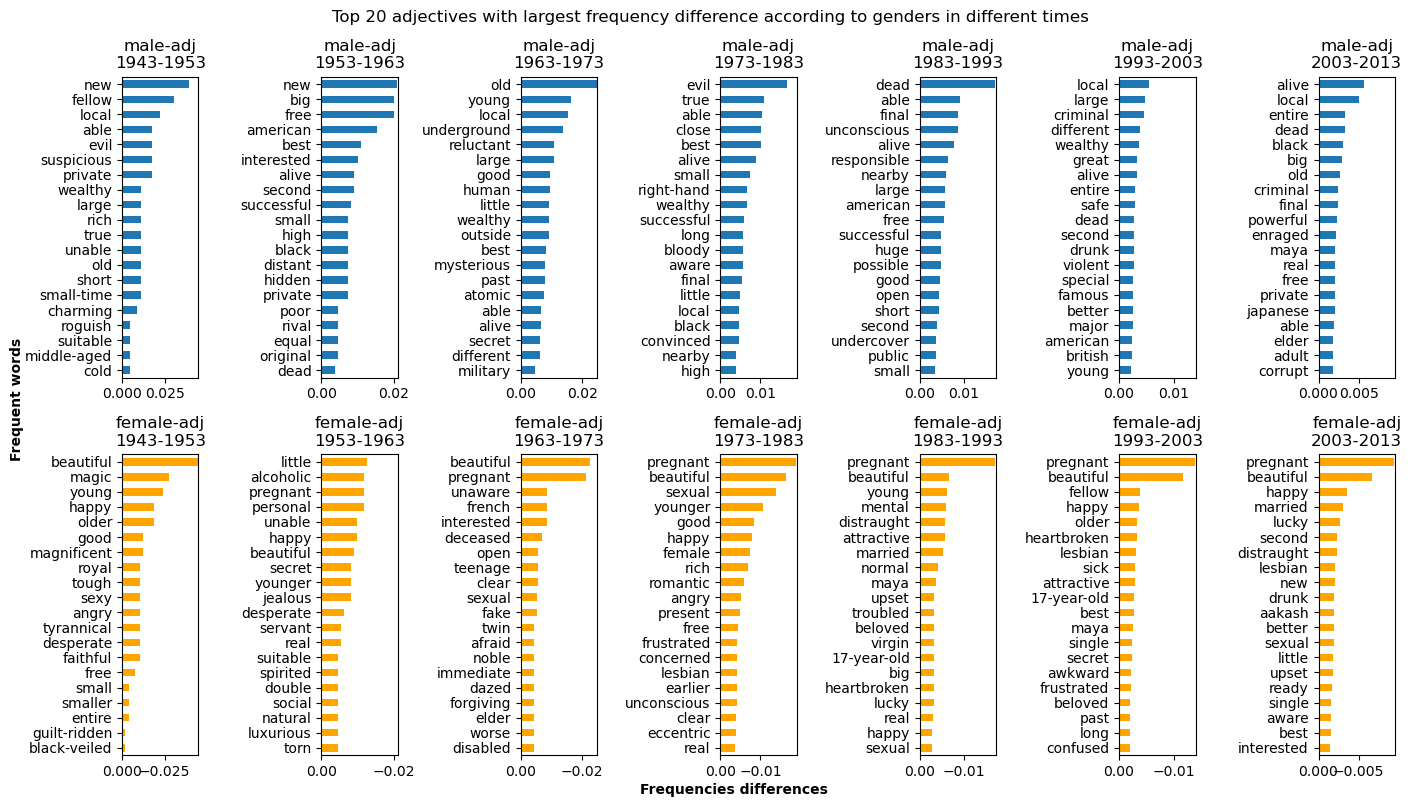

In [235]:
fig, axes = plt.subplots(2, 7, figsize=(14, 8))
axes = axes.ravel()
fig.suptitle(
    "Top 20 adjectives with largest frequency difference according to genders in different times"
)

for idx, time_span in enumerate(time_spans[3:]):
    word_type = "adj"
    male_words = diff_dict_with_time[time_span][word_type].freq_diff.sort_values()[-20:]
    female_words = diff_dict_with_time[time_span][word_type].freq_diff.sort_values(ascending=False)[-20:]
    ax1 = male_words.plot.barh(
        ax=axes[idx], legend=False, title="male-{}\n{}-{}".format(word_type, round(time_span.left), round(time_span.right))
    )
    ax1.set_xlim(0.000, max(abs(male_words).max(), abs(female_words).max())*1.01)
    ax2 = female_words.plot.barh(
        ax=axes[idx + 7],
        color="orange",
        legend=False,
        title="female-{}\n{}-{}".format(word_type, round(time_span.left), round(time_span.right)),
    )
    ax2.set_xlim(0.000, -max(abs(male_words).max(), abs(female_words).max())*1.01)

fig.text(0.45, 0, "Frequencies differences", weight="bold")
fig.text(0, 0.42, "Frequent words", rotation=90, weight="bold")
plt.tight_layout()
plt.show()

We can find that the trends are similar for different decades, and coherent with the overall analysis. Looking at the scale of x-axis, however, we notice a decreasing of absolute value (0.02 to 0.01 in verbs and 0.025 to 0.005 in adjectives). This may tell us that the bias exists, but it is decreasing with time. Next, we will do the quantitative analysis to further check it.

#### Quantitative Analysis

We use the linear regression to see the relation between KL divergence (y) and decades (x).

In [236]:
x = np.arange(1, 8)
y_verb = []
y_adj = []
time = []

for time_span, diff_dict in diff_dict_with_time.items():
    time.append(time_span)
    y_verb.append(KL(diff_dict["verb"].sort_index().freq_m, diff_dict["verb"].sort_index().freq_f))
    y_adj.append(KL(diff_dict["adj"].sort_index().freq_m, diff_dict["adj"].sort_index().freq_f))

time = time[3:]
y_verb = np.array(y_verb)[3:]
y_adj = np.array(y_adj)[3:]

In [237]:
df_reg_verb = pd.DataFrame({
    'x': x,
    'y': y_verb,
    'time_span': time
})
df_reg_adj = pd.DataFrame({
    'x': x,
    'y': y_adj,
    'time_span': time
})

model_verb = smf.ols(formula='y ~ x', data=df_reg_verb)
model_adj = smf.ols(formula='y ~ x', data=df_reg_adj)
np.random.seed(2)
result_verb = model_verb.fit()
result_adj = model_adj.fit()

In [238]:
print("======verb======")
print(result_verb.summary())

======verb======
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     33.28
Date:                Wed, 21 Dec 2022   Prob (F-statistic):            0.00220
Time:                        07:14:54   Log-Likelihood:                 17.640
No. Observations:                   7   AIC:                            -31.28
Df Residuals:                       5   BIC:                            -31.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2639      0.019   

/home/fyy/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


In [239]:
print("======adj======")
print(result_adj.summary())

======adj======
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     4.887
Date:                Wed, 21 Dec 2022   Prob (F-statistic):             0.0780
Time:                        07:15:19   Log-Likelihood:                 15.013
No. Observations:                   7   AIC:                            -26.03
Df Residuals:                       5   BIC:                            -26.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2844      0.028    

/home/fyy/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


In [243]:
sns.regplot(x='x', y='y', data=df_reg_verb, label="verb")
sns.regplot(x='x', y='y', data=df_reg_adj, label="adjective")
plt.title("Linear regression between KL divergence (y) and decades (x)")
plt.legend()
plt.xlabel("Decades")
plt.ylabel("KL divergence")
plt.show()

We could see that the KL divergence is decreasing! And the p-value of verb is below 0.05, showing the result is quite meaningful! Another question is that if the difference today still significant?

In [244]:
# compute the chi-square p-value from 2003 to 2013

last_span = time_spans[-1]
diff_dict = diff_dict_with_time[last_span]
print(f'verb (scale to the count of relevant words of males):   {stats.chisquare(diff_dict["verb"].sort_index().count_m, diff_dict["verb"].sort_index().count_m.sum()*diff_dict["verb"].sort_index().freq_f)}')
print(f'verb (scale to the count of relevant words of females): {stats.chisquare(diff_dict["verb"].sort_index().count_f, diff_dict["verb"].sort_index().count_f.sum()*diff_dict["verb"].sort_index().freq_m)}')
print(f'adj (scale to the count of relevant words of males):    {stats.chisquare(diff_dict["adj"].sort_index().count_m, diff_dict["adj"].sort_index().count_m.sum()*diff_dict["adj"].sort_index().freq_f)}')
print(f'adj (scale to the count of relevant words of females):  {stats.chisquare(diff_dict["adj"].sort_index().count_f, diff_dict["adj"].sort_index().count_f.sum()*diff_dict["adj"].sort_index().freq_m)}')

verb (scale to the count of relevant words of males):   Power_divergenceResult(statistic=10043.382514619308, pvalue=0.0)
verb (scale to the count of relevant words of females): Power_divergenceResult(statistic=4660.925534367175, pvalue=4.83837663678155e-309)
adj (scale to the count of relevant words of males):    Power_divergenceResult(statistic=4131.370372833231, pvalue=0.0)
adj (scale to the count of relevant words of females):  Power_divergenceResult(statistic=2913.6626047304153, pvalue=9.322588446103035e-141)


Yes, the bias still exists today.

### Comparison between genres

After discussion, the comparison between genres will not be in our part of story. So we will briefly present the result here.

#### Look at the distribution

In [245]:
genres_count = Counter(movies_plots_filtered.genres.sum())

In [246]:
genres_distribution = pd.DataFrame.from_dict(genres_count, orient="index", columns=["count"]).sort_values(by="count", ascending=False)
ax = genres_distribution.iloc[:100].plot(xticks = np.arange(100), rot=70, logy=True, legend=False, figsize=(20, 8))
plt.xticks(ha="right")
plt.ylabel("Count")
plt.xlabel("Genre")
plt.title("Count of top 100 genres")
plt.tight_layout()
plt.show()

We only count the top 100 genres and it is long-tailed. Besides, the genre type has some overlaps (Romance film and Romance drama). So we just choose 10 main genres: Action, Adventure, Comedy, Drama, Horror, Romance Film, Science Fiction, Fantasy, Thriller, Family Film.

In [247]:
def is_genre(genre_list, genre="Drama"):
    return genre in genre_list


tmp = movies_plots_filtered.copy()

if not os.path.exists(gender_dict_with_genre_path):
    gender_dict_with_genre = {}
    for genre in "Action, Adventure, Comedy, Drama, Horror, Romance Film, Science Fiction, Fantasy, Thriller, Family Film".split(", "):
        group = tmp[tmp.genres.apply(lambda f: is_genre(f, genre))==True]
        gen_dict = {
            "M": {"all": {}, "noun": {}, "verb": {}, "adj": {}},
            "F": {"all": {}, "noun": {}, "verb": {}, "adj": {}},
        }
        # compute the word frequency every ten years
        gender_dict_with_genre[genre] = extract_word_frequency(group, gen_dict, pos_mapping, summary_path, window_size=window_size)

    # create a binary pickle file
    with open(gender_dict_with_genre_path, "wb") as f:
        # write the python object (dict) to pickle file
        pickle.dump(gender_dict_with_genre, f)

else:
    with open(gender_dict_with_genre_path, "rb") as f:
        gender_dict_with_genre = pickle.load(f)

In [248]:
for genre, gen_dict in gender_dict_with_genre.items():
    for gender, inner_dict in gen_dict.items():
        for word_type, freq_dict in inner_dict.items():
            for stopword in spacy_stopwords:
                    freq_dict.pop(stopword.lower(), None)

In [249]:
diff_dict_with_genre = {}
male_dict_with_genre = {}
female_dict_with_genre = {}

for genre, gen_dict in gender_dict_with_genre.items():
    male_dict_with_genre[genre] = {}
    female_dict_with_genre[genre] = {}
    diff_dict_with_genre[genre] = {}
    for idx, word_type in enumerate(["all", "noun", "verb", "adj"]):
        male_words = pd.DataFrame.from_dict(
            gen_dict["M"][word_type], orient="index", columns=["count"]
        ).sort_values(by=["count"])
        male_dict_with_genre[genre][word_type] = male_words

        female_words = pd.DataFrame.from_dict(
            gen_dict["F"][word_type], orient="index", columns=["count"]
        ).sort_values(by=["count"])
        female_dict_with_genre[genre][word_type] = female_words

        diff_words = pd.concat([male_words, female_words], axis=1).dropna()
        diff_words.columns = ["count_m", "count_f"]
        diff_words.fillna(0, inplace=True)
        diff_words["freq_m"] = diff_words["count_m"] / diff_words["count_m"].sum()
        diff_words["freq_f"] = diff_words["count_f"] / diff_words["count_f"].sum()
        diff_words["freq_diff"] = diff_words.freq_m - diff_words.freq_f
        diff_dict_with_genre[genre][word_type] = diff_words

#### Qualitative

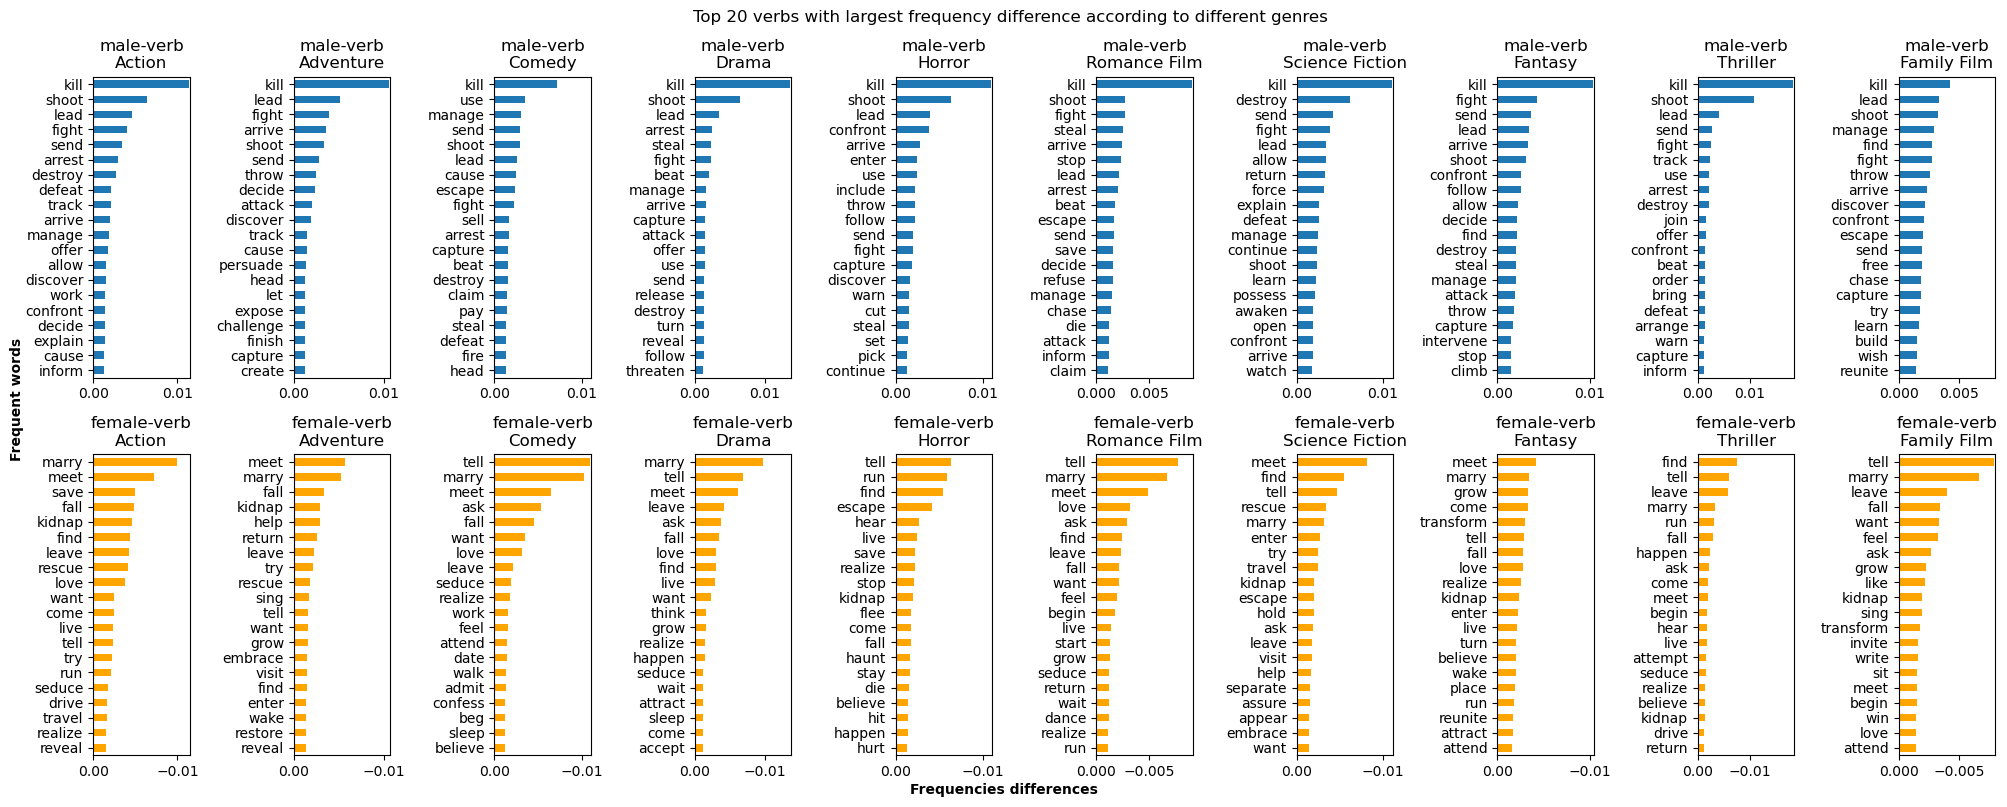

In [250]:
genres = list(gender_dict_with_genre.keys())

fig, axes = plt.subplots(2, 10, figsize=(20, 8))
axes = axes.ravel()
fig.suptitle(
    "Top 20 verbs with largest frequency difference according to different genres"
)

for idx, genre in enumerate(genres):
    word_type = "verb"
    male_words = diff_dict_with_genre[genre][word_type].freq_diff.sort_values()[-20:]
    female_words = diff_dict_with_genre[genre][word_type].freq_diff.sort_values(ascending=False)[-20:]
    ax1 = male_words.plot.barh(
        ax=axes[idx], legend=False, title="male-{}\n{}".format(word_type, genre)
    )
    ax1.set_xlim(0.000, max(abs(male_words).max(), abs(female_words).max())*1.01)
    ax2 = female_words.plot.barh(
        ax=axes[idx + 10],
        color="orange",
        legend=False,
        title="female-{}\n{}".format(word_type, genre),
    )
    ax2.set_xlim(0.000, -max(abs(male_words).max(), abs(female_words).max())*1.01)

fig.text(0.45, 0, "Frequencies differences", weight="bold")
fig.text(0, 0.42, "Frequent words", rotation=90, weight="bold")
plt.tight_layout()
plt.show()

In [251]:
fig, axes = plt.subplots(2, 10, figsize=(20, 8))
axes = axes.ravel()
fig.suptitle(
    "Top 20 adjectives with largest frequency difference according to different genres"
)

for idx, genre in enumerate(genres):
    word_type = "adj"
    male_words = diff_dict_with_genre[genre][word_type].freq_diff.sort_values()[-20:]
    female_words = diff_dict_with_genre[genre][word_type].freq_diff.sort_values(ascending=False)[-20:]
    ax1 = male_words.plot.barh(
        ax=axes[idx], legend=False, title="male-{}\n{}".format(word_type, genre)
    )
    ax1.set_xlim(0.000, max(abs(male_words).max(), abs(female_words).max())*1.01)
    ax2 = female_words.plot.barh(
        ax=axes[idx + 10],
        color="orange",
        legend=False,
        title="female-{}\n{}".format(word_type, genre),
    )
    ax2.set_xlim(0.000, -max(abs(male_words).max(), abs(female_words).max())*1.01)

fig.text(0.45, 0, "Frequencies differences", weight="bold")
fig.text(0, 0.42, "Frequent words", rotation=90, weight="bold")
plt.tight_layout()
plt.show()

Again, we see a similar bias with the overall analysis.

#### Quantitative

We only compare the verbs, because the number of adjectives for females is not large enough.

In [256]:
# compare KL divergence between genres

divergences_KL_verb = []
divergences_KL_adj = []

for genre, diff_dict in diff_dict_with_genre.items():
    divergences_KL_verb.append(KL(diff_dict["verb"].sort_index().freq_m, diff_dict["verb"].sort_index().freq_f))
    divergences_KL_adj.append(KL(diff_dict["adj"].sort_index().freq_m, diff_dict["adj"].sort_index().freq_f))

plt.bar(genres, divergences_KL_adj, label="adjectives")
plt.bar(genres, divergences_KL_verb, label="verb")
plt.legend()
plt.xticks(ha="right", rotation=45)
plt.ylabel("KL divergence")
plt.xlabel("Genre")
plt.title("KL divergence of different genres")
plt.tight_layout()
plt.show()

The trend of KL divergence is similar between verb and adjective. Romance films have the least KL divergence.

In [258]:
least_div_genre = "Romance Film"

print(f'verb (scale to the count of relevant words of males):   {stats.chisquare(diff_dict_with_genre[least_div_genre]["verb"].sort_index().count_m, diff_dict_with_genre[least_div_genre]["verb"].sort_index().count_m.sum()*diff_dict_with_genre[least_div_genre]["verb"].sort_index().freq_f)}')
print(f'verb (scale to the count of relevant words of females): {stats.chisquare(diff_dict_with_genre[least_div_genre]["verb"].sort_index().count_f, diff_dict_with_genre[least_div_genre]["verb"].sort_index().count_f.sum()*diff_dict_with_genre[least_div_genre]["verb"].sort_index().freq_m)}')
print(f'adj (scale to the count of relevant words of males):    {stats.chisquare(diff_dict_with_genre[least_div_genre]["adj"].sort_index().count_m, diff_dict_with_genre[least_div_genre]["adj"].sort_index().count_m.sum()*diff_dict_with_genre[least_div_genre]["adj"].sort_index().freq_f)}')
print(f'adj (scale to the count of relevant words of females):  {stats.chisquare(diff_dict_with_genre[least_div_genre]["adj"].sort_index().count_f, diff_dict_with_genre[least_div_genre]["adj"].sort_index().count_f.sum()*diff_dict_with_genre[least_div_genre]["adj"].sort_index().freq_m)}')

verb (scale to the count of relevant words of males):   Power_divergenceResult(statistic=4073.315372432018, pvalue=0.0)
verb (scale to the count of relevant words of females): Power_divergenceResult(statistic=2729.4106661805436, pvalue=4.397949582114112e-136)
adj (scale to the count of relevant words of males):    Power_divergenceResult(statistic=2094.028506522889, pvalue=2.2303384505888704e-104)
adj (scale to the count of relevant words of females):  Power_divergenceResult(statistic=1713.0109832605963, pvalue=5.484757581130817e-59)


The bias is obvious even in the romance films.

## Time evolution of gender difference in the movie industry

In [36]:
movie_char = pd.merge(
    movies, characters, left_on="wikipedia_id", right_on="wikipedia_id"
)

In [37]:
# We are dealing with the sex stats, thus the NA values of actor_genders are not helpful.
# Here we remove columns with NA actor_gender values.
movie_char = movie_char.dropna(subset=["actor_gender"])

In [38]:
# transforming the sex data into a more flexible format.
movie_char["MaleActor"] = (movie_char.actor_gender == "M").astype(int)
movie_char["FemaleActor"] = (movie_char.actor_gender == "F").astype(int)

In [39]:
# Grouping by the data by films. In each grouped dataframe, summing the sex stats of male and female, we get the gender sum of each flim.

# Also, use: characters.groupby('A').B.agg(['min', 'max'])
movie_char_GpBy = movie_char.groupby(by="wikipedia_id")

In [40]:
SexStats = movie_char_GpBy.apply(lambda x: x[["MaleActor", "FemaleActor"]].sum())
SexStats = SexStats.rename(
    columns={"MaleActor": "MaleCount", "FemaleActor": "FemaleCount"}
)

In [41]:
SexStats

MaleCount  FemaleCount
wikipedia_id                        
330                   0            4
3217                 10            3
3333                  8            6
3746                 11            3
3837                 18            2
...                 ...          ...
37322106              1            2
37373877              3            3
37476824              6            4
37478048              3            1
37501922              1            1

[59968 rows x 2 columns]

In [42]:
movie_gender = pd.merge(movies, SexStats, left_on="wikipedia_id", right_index=True)

We have counted the apprearence of male, female actors in each film, and stored them in the column: '**MaleCount**', '**FemaleCount**'

**Please also note that**: the result is derived after removing the rows with the 'Actor_gender' being NA.

In [43]:
movie_gender.head()

wikipedia_id freebase_id  \
0        975900   /m/03vyhn   
1       3196793   /m/08yl5d   
2      28463795  /m/0crgdbh   
3       9363483  /m/0285_cd   
4        261236   /m/01mrr1   

                                                name release_date  \
0                                     Ghosts of Mars         2001   
1  Getting Away with Murder: The JonBenét Ramsey ...         2000   
2                                        Brun bitter         1988   
3                                   White Of The Eye         1987   
4                                  A Woman in Flames         1983   

   box_office_revenue  runtime    languages                   countries  \
0          14010832.0     98.0    [English]  [United States of America]   
1                 NaN     95.0    [English]  [United States of America]   
2                 NaN     83.0  [Norwegian]                    [Norway]   
3                 NaN    110.0    [English]            [United Kingdom]   
4                 NaN    106.0     [German]                   [Germany]   

                                              genres  MaleCount  FemaleCount  
0  [Thriller, Science Fiction, Horror, Adventure,...         11            6  
1   [Mystery, Biographical film, Drama, Crime Drama]         11            4  
2                             [Crime Fiction, Drama]          2            2  
3  [Thriller, Erotic thriller, Psychological thri...          1            1  
4                                            [Drama]          2            1

In [44]:
# We want to see how the difference of Male, Female actors numbers change over time.

# We are dealing with time, so NA time for us is not useful. We drop rows with NA release_date values
movie_gender = movie_gender.dropna(subset=["release_date"])

# We only care about the year time, so we cut the year from the Release_data column, and place the year at column 'Release_year'
movie_gender.loc[:, "release_year"] = movie_gender.release_date.apply(
    lambda x: str(x)[0:4]
)

# Derive the male--female difference
movie_gender.loc[:, "SexDiff"] = movie_gender.MaleCount - movie_gender.FemaleCount

# Sorting by time
movie_gender = movie_gender.sort_values(by="release_year").copy()

Note that we have huge data variance in the first the last few years, data may not be representative. The pattern we observe here is somewhat different.

- Ratio start to be close to 1, then goes up, finally goes down.

**We are interested in how may films are released in each year. If there are few films released that year, data at that year may not be repesentative.**

In [48]:
# deriving the annual release data
release_num_yr = movie_gender.groupby(by="release_year").wikipedia_id.agg("count")
release_num_yr

release_num_yr.describe()

count     126.000000
mean      475.936508
std       438.101682
min         1.000000
25%       224.500000
50%       394.500000
75%       563.750000
max      1955.000000
Name: wikipedia_id, dtype: float64

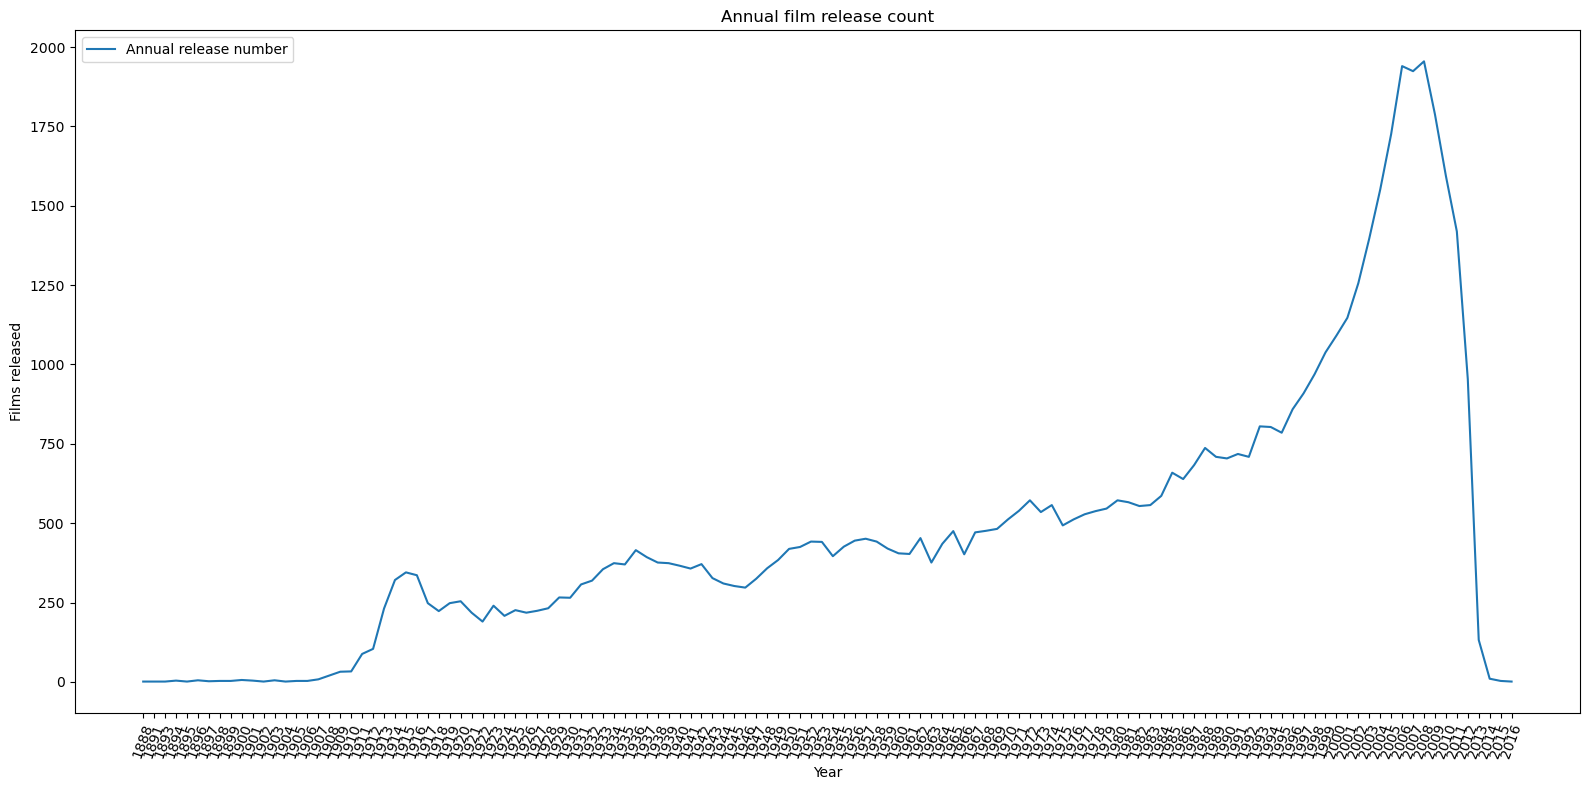

In [49]:
# Plotting the annual release stats.
plt.figure(figsize=(16, 8))
ax = sns.lineplot(
    data=release_num_yr,
    x=release_num_yr.index,
    y=release_num_yr.values,
    legend="full",
    label="Annual release number",
)
ax.set_xticks(np.unique(sex_ratio.release_year.values))
ax.set_xticklabels(np.unique(sex_ratio.release_year.values), rotation=70)
plt.xlabel("Year")
plt.ylabel("Films released")
plt.title("Annual film release count")
plt.tight_layout()
plt.show()

In [50]:
release_num_df = pd.DataFrame(release_num_yr)
release_num_df.columns = ["annual_count"]
release_num_df.hist()
release_num_df[release_num_df.annual_count < 250].hist()

array([[<AxesSubplot:title={'center':'annual_count'}>]], dtype=object)

In [51]:
release_num_df[release_num_df.annual_count < 50]

annual_count
release_year              
1888                     1
1891                     1
1893                     1
1894                     4
1895                     1
1896                     5
1897                     2
1898                     3
1899                     3
1900                     6
1901                     4
1902                     1
1903                     5
1904                     1
1905                     3
1906                     3
1907                     8
1908                    20
1909                    32
1910                    33
2014                    10
2015                     3
2016                     1

In [52]:
movie_gender_trimmed = movie_gender[
    (movie_gender.release_year < "2014") & (movie_gender.release_year > "1910")
]

In [54]:
# Plotting the annual actor count difference by sex. Do we see any patterns in their variance?
plt.figure(figsize=(10, 5))
ax = sns.lineplot(
    data=movie_gender_trimmed,
    x="release_year",
    y="SexDiff",
    legend="full",
    label="SexDiff",
)
ax.set_xticks(np.unique(movie_gender_trimmed.release_year.values))
ax.set_xticklabels(np.unique(movie_gender_trimmed.release_year.values), rotation=70)
plt.xlabel("Year Release")
plt.ylabel("Mean Sex Diff Each Year")
plt.title("Annual actor/actress count difference by sex")
plt.tight_layout()
plt.show()

In [55]:
# Plotting the annual actor count ratio by sex. Do we see any patterns in their variance?
movie_gender_GpBy_time = movie_gender_trimmed.groupby(by="release_year")
male_count_year = movie_gender_GpBy_time.apply(lambda x: x.MaleCount.sum())
female_count_year = female_sum = movie_gender_GpBy_time.apply(
    lambda x: x.FemaleCount.sum()
)
sex_ratio = male_count_year / female_count_year


sex_ratio = pd.DataFrame(sex_ratio, columns=["M/F_ratio"]).reset_index()

# Plotting
plt.figure(figsize=(10, 5))
ax = sns.lineplot(
    data=sex_ratio, x="release_year", y="M/F_ratio", legend="full", label="SexRatio"
)
ax.set_xticks(np.unique(sex_ratio.release_year.values))
ax.set_xticklabels(np.unique(sex_ratio.release_year.values), rotation=70)
plt.xlabel("Year Release")
plt.ylabel("Sex Ratio Each Year")
plt.title("Annual actor/actress count difference by sex")
plt.tight_layout()
plt.show()

__Some analysis:__
We assume that:

$ \frac{Male}{Female} = f(t) $

Therefore we have:

$Male - Female = Female(f(t) - 1)$

We observe that:
- $Male - Female = Female(f(t) - 1)$ increases to summit at 1941, then decreases and stays stable.
- $\frac{Male}{Female} = f(t)$  increases to summit at 1941, then decreases all the way.

We conclude that the ratio of male-female attendance in films first increases (perhaps because of WWII!) then decreases (peace!) but genreally there are more men than
women in the movie industry.

To count for the stable variation of actors count difference, we explain that it is because the increase of absolute number of women actress.

## Gender career difference

In [159]:
characters_with_year = characters.copy()
characters_with_year = characters_with_year[
    characters_with_year["release_date"] != "nan"
]

characters_with_year.loc[:, "release_date"] = characters_with_year.release_date.apply(
    lambda x: int(x)
).copy()
print(characters_with_year.shape)
characters_with_year.head()

(440674, 13)


wikipedia_id freebase_id  release_date              character_name  \
0        975900   /m/03vyhn          2001                    Akooshay   
1        975900   /m/03vyhn          2001  Lieutenant Melanie Ballard   
2        975900   /m/03vyhn          2001         Desolation Williams   
3        975900   /m/03vyhn          2001          Sgt Jericho Butler   
4        975900   /m/03vyhn          2001             Bashira Kincaid   

    actor_dob actor_gender  actor_height actor_ethnicity          actor_name  \
0  1958-08-26            F         1.620             NaN      Wanda De Jesus   
1  1974-08-15            F         1.780      /m/044038p  Natasha Henstridge   
2  1969-06-15            M         1.727         /m/0x67            Ice Cube   
3  1967-09-12            M         1.750             NaN       Jason Statham   
4  1977-09-25            F         1.650             NaN         Clea DuVall   

   actor_age freebase_character_map freebase_character_id freebase_actor_id  
0       42.0             /m/0bgchxw            /m/0bgcj3x        /m/03wcfv7  
1       27.0              /m/0jys3m            /m/0bgchn4         /m/0346l4  
2       32.0              /m/0jys3g            /m/0bgchn_        /m/01vw26l  
3       33.0             /m/02vchl6            /m/0bgchnq         /m/034hyc  
4       23.0             /m/02vbb3r            /m/0bgchp9         /m/01y9xg

### Actor age evolution for genders

In [160]:
female = characters_with_year[characters_with_year["actor_gender"] == "F"]
male = characters_with_year[characters_with_year["actor_gender"] == "M"]

female_age = female[female["actor_age"] >= 0][["actor_age", "release_date"]]
male_age = male[male["actor_age"] >= 0][["actor_age", "release_date"]]

female_age.head()

actor_age  release_date
0       42.0          2001
1       27.0          2001
4       23.0          2001
5       52.0          2001
6       56.0          2001

In [161]:
print(female_age[female_age["release_date"] < 1920].shape)
print(male_age[male_age["release_date"] < 1920].shape)

(110, 2)
(36, 2)


We can see the avalaible data earliear than 1920 are really few. It is reasonable not to use this part of data afterwards.

In [162]:
plt.figure(figsize=(8, 4))

ax = sns.lineplot(
    data=female_age,
    x="release_date",
    y="actor_age",
    legend="full",
    label="average age of female actors",
)
ax = sns.lineplot(
    data=male_age,
    x="release_date",
    y="actor_age",
    legend="full",
    label="average age of male actors",
)
plt.xlabel("time")
plt.ylabel("age")
plt.tight_layout()
plt.title(
    "Average Age of Actors",
)
plt.show()

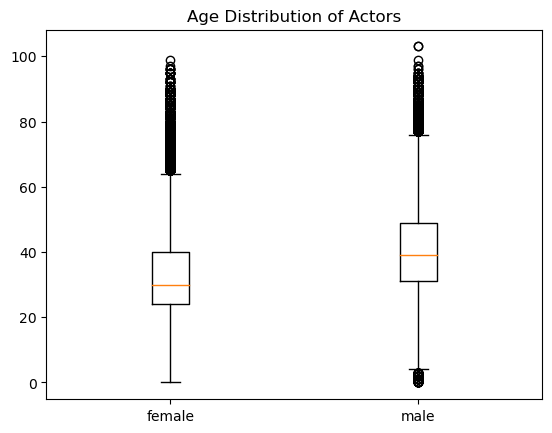

In [163]:
age_dis = [female_age["actor_age"].values, male_age["actor_age"].values]
plt.boxplot(age_dis, labels=["female", "male"])
plt.title("Age Distribution of Actors")
plt.show()

In [164]:
stats.ttest_ind(female_age["actor_age"], male_age["actor_age"])

Ttest_indResult(statistic=-140.92509242040052, pvalue=0.0)

### Analysis of age plots

- ttest p value equals zero, which means mean value of the two distribution are totally different
- The lineplots also show the average age actors through years. Female actors are generally younger than male actors when they play actors in movies since 1935s. From 1925s to 1935s, average age is roughly same. From 1915s to 1925s, female actors are younger. For previous years, the total actor counts of whom are notated with yearsare less than 50, it is too small a dataset size to draw some feasible conclustions.
- The lineplots also shows an ascending trend in age of both female and male actors, but with different time periods and gradually become flat in recent years.

Filter abnormal data

In [165]:
# max = 90
female_filtered= female.drop(female[female['actor_age']<0].index).dropna()
female_filtered.actor_age.plot(kind = "hist", bins = 90)
plt.title("Female characters age distribution")
plt.xlabel("Age")
plt.ylabel("Counts")
plt.show()

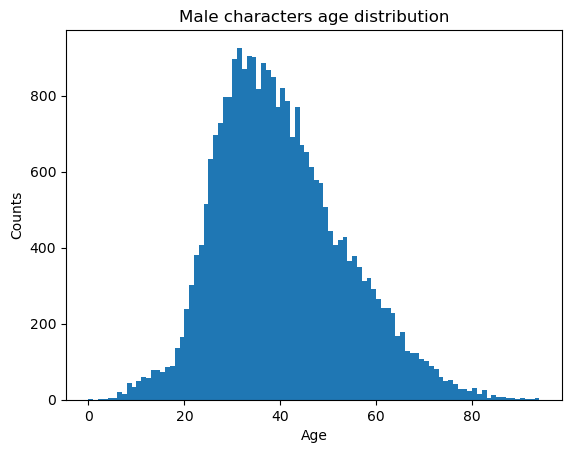

In [166]:
# max = 94
male_filtered= male.drop(male[male['actor_age']<0].index).dropna()
male_filtered.actor_age.plot(kind = "hist", bins = 94)
plt.title("Male characters age distribution")
plt.xlabel("Age")
plt.ylabel("Counts")
plt.show()

In [49]:
def find_age_range(df):
    grouped = df.groupby(by =  'freebase_actor_id')
    ages = grouped.agg({'actor_name': lambda x: x.mode(), 'actor_dob': lambda x: x.mode(), 'actor_age':['min', 'max',lambda x: np.mean(x.mode())]}).reset_index()
    ages['span'] = ages['actor_age','max']-ages['actor_age','min']+1
    return ages

female_age_span = find_age_range(female_filtered)
male_age_span = find_age_range(male_filtered)

In [52]:
female_age_span['birth_year'] = female_age_span['actor_dob','<lambda>'].apply(lambda x: int(extract_year(x)))
female_age_span.head()

freebase_actor_id          actor_name   actor_dob actor_age        \
                               <lambda>    <lambda>       min   max   
0         /m/011zd3            Lucy Liu  1968-12-02      26.0  43.0   
1         /m/0127s7  Christina Aguilera  1980-12-18      29.0  29.0   
2         /m/012gbb    Marlene Dietrich  1901-12-27      28.0  77.0   
3         /m/012gl8    Nichelle Nichols  1932-12-28      46.0  74.0   
4         /m/012s5j        Raquel Welch  1940-09-05      23.0  65.0   

              span birth_year  
  <lambda_0>                   
0  28.000000  18.0       1968  
1  29.000000   1.0       1980  
2  46.333333  50.0       1901  
3  57.000000  29.0       1932  
4  28.500000  43.0       1940

In [53]:
female_age_span.span.describe()

count    1462.000000
mean       14.076607
std        12.698457
min         1.000000
25%         4.000000
50%        11.000000
75%        20.000000
max        69.000000
Name: span, dtype: float64

In [60]:
male_age_span['birth_year'] = male_age_span['actor_dob','<lambda>'].apply(lambda x: int(extract_year(x)))
male_age_span.span.describe()

count    1857.000000
mean       17.602585
std        13.765014
min         1.000000
25%         7.000000
50%        15.000000
75%        26.000000
max        74.000000
Name: span, dtype: float64

In [28]:
stats.ttest_ind(female_age_span.span, male_age_span.span,alternative = 'less')

Ttest_indResult(statistic=-7.579058102005843, pvalue=2.2444630262020802e-14)

In [29]:
stats.kstest(female_age_span.span, male_age_span.span, alternative='greater')

KstestResult(statistic=0.1307799747618174, pvalue=6.214787048536377e-13)

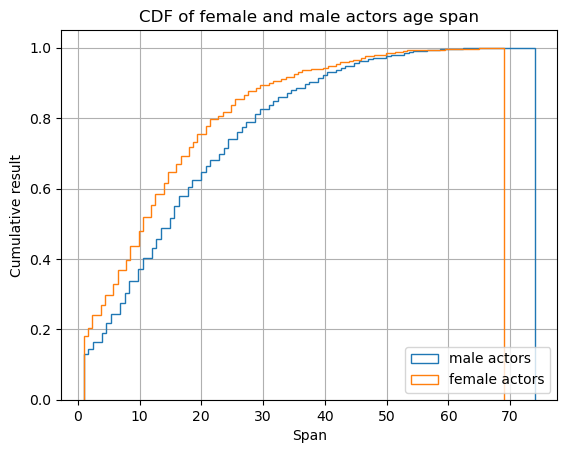

In [30]:
ax = male_age_span.span.hist( cumulative = True, density=1, bins =100, histtype = 'step', label='male actors' )
ax = female_age_span.span.hist( cumulative = True, density=1, bins =100, histtype = 'step', label='female actors' )
plt.legend(loc = "lower right")
plt.title('CDF of female and male actors age span')
plt.xlabel('Span')
plt.ylabel('Cumulative result')
plt.show()

In [55]:
female_age_span.head()

freebase_actor_id          actor_name   actor_dob actor_age        \
                               <lambda>    <lambda>       min   max   
0         /m/011zd3            Lucy Liu  1968-12-02      26.0  43.0   
1         /m/0127s7  Christina Aguilera  1980-12-18      29.0  29.0   
2         /m/012gbb    Marlene Dietrich  1901-12-27      28.0  77.0   
3         /m/012gl8    Nichelle Nichols  1932-12-28      46.0  74.0   
4         /m/012s5j        Raquel Welch  1940-09-05      23.0  65.0   

              span birth_year  
  <lambda_0>                   
0  28.000000  18.0       1968  
1  29.000000   1.0       1980  
2  46.333333  50.0       1901  
3  57.000000  29.0       1932  
4  28.500000  43.0       1940

In [56]:
female_age_span.birth_year.describe()

count    1462.000000
mean     1968.023256
std        17.321994
min      1901.000000
25%      1961.000000
50%      1972.000000
75%      1980.000000
max      2000.000000
Name: birth_year, dtype: float64

In [61]:
male_age_span.birth_year.describe()

count    1857.000000
mean     1959.998923
std        18.890194
min      1900.000000
25%      1948.000000
50%      1964.000000
75%      1973.000000
max      1998.000000
Name: birth_year, dtype: float64

In [63]:
females = []
males = []
for i in range(10):
    left = 1900 + i*10
    right = 1900 + (i+1) * 10
    if i==9:
        right+=1
    female = female_age_span[female_age_span.birth_year.isin(range(left, right))]
    male = male_age_span[male_age_span.birth_year.isin(range(left, right))]
    females.append(female)
    males.append(male)

females[5].describe()

actor_age                                span   birth_year
              min         max  <lambda_0>                         
count  139.000000  139.000000  139.000000  139.000000   139.000000
mean    29.402878   48.841727   39.508513   20.438849  1954.956835
std     10.460914    9.609219   10.834847   12.856575     2.750153
min      7.000000   20.000000   18.000000    1.000000  1950.000000
25%     23.000000   46.000000   31.250000   11.000000  1952.000000
50%     27.000000   52.000000   40.000000   22.000000  1955.000000
75%     35.000000   55.000000   48.500000   29.000000  1957.000000
max     58.000000   62.000000   60.000000   50.000000  1959.000000

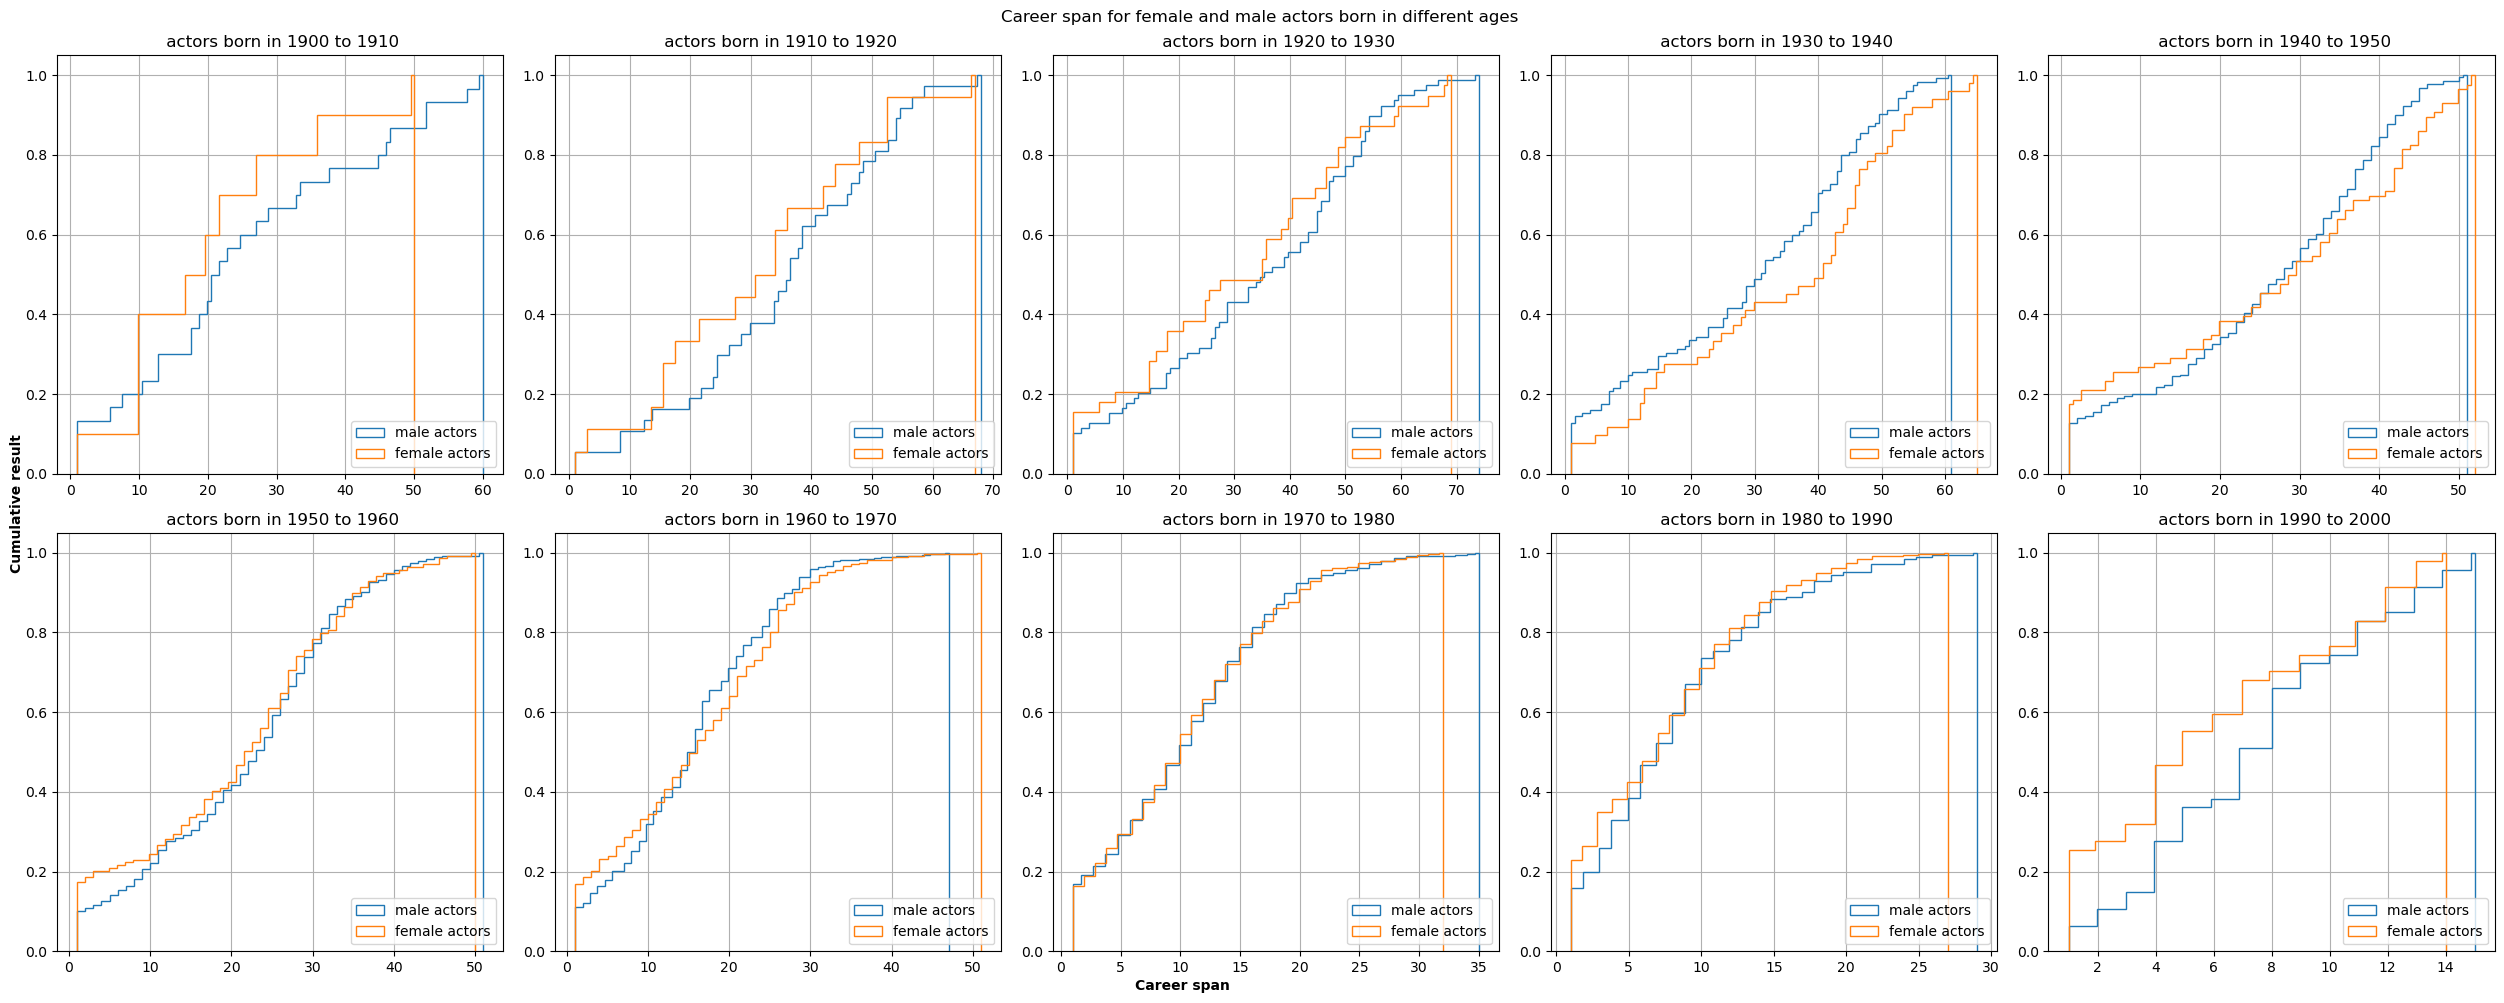

In [89]:
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.ravel()
fig.suptitle(
    "Career span for female and male actors born in different ages"
)

for i in range(10):
    males[i].span.hist( ax = axes[i], cumulative = True, density=1, bins =100, histtype = 'step', label='male actors' )
    females[i].span.hist( ax = axes[i], cumulative = True, density=1, bins =100, histtype = 'step', label='female actors' )
    axes[i].legend(loc = "lower right")
    axes[i].title.set_text(' actors born in {} to {}'.format(1900+i*10, 1900+(i+1)*10))
    

fig.text(0.45, 0, "Career span", weight="bold")
fig.text(0, 0.42, "Cumulative result", rotation=90, weight="bold")
plt.tight_layout()
plt.show()

### Analysis of age span
- In the description, mean, 25%-50%-75% quantiles of female actor age span are all smaller than male's.
- From ttest result, we see the average of female actor age span is indeed smaller than male's.
- From the kstest result and cdf plots we see in CDF of female actor age span $F(x)$ and male age span $G(x)$, for every x, $F(x)$ is greater than $G(x)$, which means the general career length of female actors are shorter than male actors.

### Market preference

In [36]:
movies['movie_year'] = movies['release_date'].apply(extract_year)
movies.head()

wikipedia_id freebase_id  \
0        975900   /m/03vyhn   
1       3196793   /m/08yl5d   
2      28463795  /m/0crgdbh   
3       9363483  /m/0285_cd   
4        261236   /m/01mrr1   

                                                name release_date  \
0                                     Ghosts of Mars   2001-08-24   
1  Getting Away with Murder: The JonBenét Ramsey ...   2000-02-16   
2                                        Brun bitter         1988   
3                                   White Of The Eye         1987   
4                                  A Woman in Flames         1983   

   box_office_revenue  runtime                           languages  \
0          14010832.0     98.0  {"/m/02h40lc": "English Language"}   
1                 NaN     95.0  {"/m/02h40lc": "English Language"}   
2                 NaN     83.0  {"/m/05f_3": "Norwegian Language"}   
3                 NaN    110.0  {"/m/02h40lc": "English Language"}   
4                 NaN    106.0   {"/m/04306rv": "German Language"}   

                                   countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   
2                     {"/m/05b4w": "Norway"}   
3             {"/m/07ssc": "United Kingdom"}   
4                    {"/m/0345h": "Germany"}   

                                              genres movie_year  
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...       2001  
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...       2000  
2  {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "D...       1988  
3  {"/m/01jfsb": "Thriller", "/m/0glj9q": "Erotic...       1987  
4                            {"/m/07s9rl0": "Drama"}       1983

In [37]:
movies_revenue = movies.loc[movies.box_office_revenue.dropna().index].reset_index()
movies_revenue.head()

index  wikipedia_id freebase_id                      name release_date  \
0      0        975900   /m/03vyhn            Ghosts of Mars   2001-08-24   
1      7      10408933  /m/02qc0j7  Alexander's Ragtime Band   1938-08-16   
2     13        171005   /m/016ywb                   Henry V   1989-11-08   
3     17         77856    /m/0kcn7              Mary Poppins   1964-08-27   
4     21        612710   /m/02wjqm            New Rose Hotel   1999-10-01   

   box_office_revenue  runtime                           languages  \
0          14010832.0     98.0  {"/m/02h40lc": "English Language"}   
1           3600000.0    106.0  {"/m/02h40lc": "English Language"}   
2          10161099.0    137.0  {"/m/02h40lc": "English Language"}   
3         102272727.0    139.0  {"/m/02h40lc": "English Language"}   
4             21521.0     92.0  {"/m/02h40lc": "English Language"}   

                                   countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   
2             {"/m/07ssc": "United Kingdom"}   
3  {"/m/09c7w0": "United States of America"}   
4  {"/m/09c7w0": "United States of America"}   

                                              genres movie_year  
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...       2001  
1  {"/m/04t36": "Musical", "/m/01z4y": "Comedy", ...       1938  
2  {"/m/04xvh5": "Costume drama", "/m/082gq": "Wa...       1989  
3  {"/m/0hj3myq": "Children's/Family", "/m/04t36"...       1964  
4  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...       1999

In [38]:
movies_revenue.box_office_revenue.describe()

count    8.401000e+03
mean     4.799363e+07
std      1.121753e+08
min      1.000000e+04
25%      2.083193e+06
50%      1.063969e+07
75%      4.071696e+07
max      2.782275e+09
Name: box_office_revenue, dtype: float64

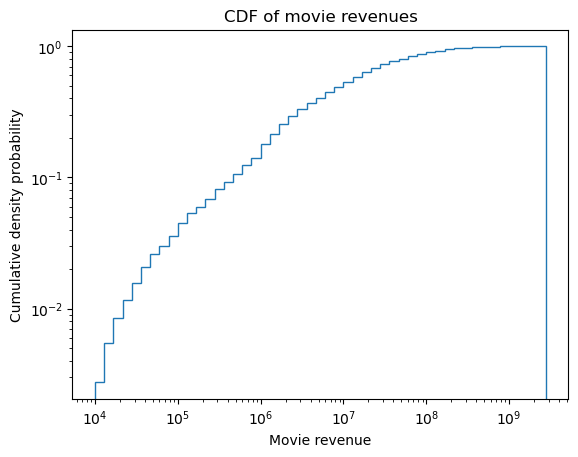

In [39]:
movies_revenue.box_office_revenue.plot(
    cumulative = True, 
    density = 1, kind = 'hist', 
    bins = np.logspace(
        np.log10(movies_revenue.box_office_revenue.min()),
        np.log10(movies_revenue.box_office_revenue.max()), 
        50), 
    loglog=True, 
    histtype = 'step')
plt.xlabel('Movie revenue')
plt.ylabel('Cumulative density probability')
plt.title("CDF of movie revenues")
plt.show()

In [40]:
def get_movie_ch_counts(df):
    ch_movies = df[df['freebase_id'].isin(movies_revenue['freebase_id'])].groupby(by='freebase_id').character_name.count()
    return(ch_movies)

f_movie_counts = get_movie_ch_counts(female)
m_movie_counts = get_movie_ch_counts(male)

In [41]:
if 'freebase_id' in movies_revenue.columns: 
    movies_revenue = movies_revenue.set_index('freebase_id')
movies_revenue['female_counts'] = f_movie_counts
movies_revenue['male_counts'] = m_movie_counts
movies_revenue.head()

index  wikipedia_id                      name release_date  \
freebase_id                                                               
/m/03vyhn        0        975900            Ghosts of Mars   2001-08-24   
/m/02qc0j7       7      10408933  Alexander's Ragtime Band   1938-08-16   
/m/016ywb       13        171005                   Henry V   1989-11-08   
/m/0kcn7        17         77856              Mary Poppins   1964-08-27   
/m/02wjqm       21        612710            New Rose Hotel   1999-10-01   

             box_office_revenue  runtime                           languages  \
freebase_id                                                                    
/m/03vyhn            14010832.0     98.0  {"/m/02h40lc": "English Language"}   
/m/02qc0j7            3600000.0    106.0  {"/m/02h40lc": "English Language"}   
/m/016ywb            10161099.0    137.0  {"/m/02h40lc": "English Language"}   
/m/0kcn7            102272727.0    139.0  {"/m/02h40lc": "English Language"}   
/m/02wjqm               21521.0     92.0  {"/m/02h40lc": "English Language"}   

                                             countries  \
freebase_id                                              
/m/03vyhn    {"/m/09c7w0": "United States of America"}   
/m/02qc0j7   {"/m/09c7w0": "United States of America"}   
/m/016ywb               {"/m/07ssc": "United Kingdom"}   
/m/0kcn7     {"/m/09c7w0": "United States of America"}   
/m/02wjqm    {"/m/09c7w0": "United States of America"}   

                                                        genres movie_year  \
freebase_id                                                                 
/m/03vyhn    {"/m/01jfsb": "Thriller", "/m/06n90": "Science...       2001   
/m/02qc0j7   {"/m/04t36": "Musical", "/m/01z4y": "Comedy", ...       1938   
/m/016ywb    {"/m/04xvh5": "Costume drama", "/m/082gq": "Wa...       1989   
/m/0kcn7     {"/m/0hj3myq": "Children's/Family", "/m/04t36"...       1964   
/m/02wjqm    {"/m/01jfsb": "Thriller", "/m/06n90": "Science...       1999   

             female_counts  male_counts  
freebase_id                              
/m/03vyhn              5.0         11.0  
/m/02qc0j7             0.0          1.0  
/m/016ywb              2.0          4.0  
/m/0kcn7               6.0          7.0  
/m/02wjqm              2.0          1.0

In [42]:
# drop movies with no actor infomation
gender_movie_revenue = movies_revenue.dropna(how = 'all', subset=['female_counts', 'male_counts'])
gender_movie_revenue = gender_movie_revenue.fillna(0)
gender_movie_revenue = gender_movie_revenue[(gender_movie_revenue['female_counts']!=0) | (gender_movie_revenue['male_counts']!=0)]
gender_movie_revenue.head()

index  wikipedia_id                      name release_date  \
freebase_id                                                               
/m/03vyhn        0        975900            Ghosts of Mars   2001-08-24   
/m/02qc0j7       7      10408933  Alexander's Ragtime Band   1938-08-16   
/m/016ywb       13        171005                   Henry V   1989-11-08   
/m/0kcn7        17         77856              Mary Poppins   1964-08-27   
/m/02wjqm       21        612710            New Rose Hotel   1999-10-01   

             box_office_revenue  runtime                           languages  \
freebase_id                                                                    
/m/03vyhn            14010832.0     98.0  {"/m/02h40lc": "English Language"}   
/m/02qc0j7            3600000.0    106.0  {"/m/02h40lc": "English Language"}   
/m/016ywb            10161099.0    137.0  {"/m/02h40lc": "English Language"}   
/m/0kcn7            102272727.0    139.0  {"/m/02h40lc": "English Language"}   
/m/02wjqm               21521.0     92.0  {"/m/02h40lc": "English Language"}   

                                             countries  \
freebase_id                                              
/m/03vyhn    {"/m/09c7w0": "United States of America"}   
/m/02qc0j7   {"/m/09c7w0": "United States of America"}   
/m/016ywb               {"/m/07ssc": "United Kingdom"}   
/m/0kcn7     {"/m/09c7w0": "United States of America"}   
/m/02wjqm    {"/m/09c7w0": "United States of America"}   

                                                        genres movie_year  \
freebase_id                                                                 
/m/03vyhn    {"/m/01jfsb": "Thriller", "/m/06n90": "Science...       2001   
/m/02qc0j7   {"/m/04t36": "Musical", "/m/01z4y": "Comedy", ...       1938   
/m/016ywb    {"/m/04xvh5": "Costume drama", "/m/082gq": "Wa...       1989   
/m/0kcn7     {"/m/0hj3myq": "Children's/Family", "/m/04t36"...       1964   
/m/02wjqm    {"/m/01jfsb": "Thriller", "/m/06n90": "Science...       1999   

             female_counts  male_counts  
freebase_id                              
/m/03vyhn              5.0         11.0  
/m/02qc0j7             0.0          1.0  
/m/016ywb              2.0          4.0  
/m/0kcn7               6.0          7.0  
/m/02wjqm              2.0          1.0

In [43]:
gender_movie_revenue['gender_diff'] = gender_movie_revenue['male_counts'] - gender_movie_revenue['female_counts']
gender_movie_revenue['total_ch'] = gender_movie_revenue['male_counts'] + gender_movie_revenue['female_counts']
gender_movie_revenue['log_rev'] = np.log(gender_movie_revenue['box_office_revenue'])
# use regulized ration in case of 0 counts
gender_movie_revenue['reg_ratio'] = (gender_movie_revenue['male_counts'] +1 )/ (gender_movie_revenue['female_counts']+1)

In [44]:
# standardlization
gender_movie_revenue['std_total_ch']  = (gender_movie_revenue['total_ch']-gender_movie_revenue['total_ch'].mean())/gender_movie_revenue['total_ch'].std()
gender_movie_revenue['std_revenue']  = (gender_movie_revenue['box_office_revenue']-gender_movie_revenue['box_office_revenue'].mean())/gender_movie_revenue['box_office_revenue'].std()
gender_movie_revenue['std_runtime'] = (gender_movie_revenue['runtime']-gender_movie_revenue['runtime'].mean())/gender_movie_revenue['runtime'].std()
gender_movie_revenue.movie_year = gender_movie_revenue.movie_year.apply(lambda x: int(x))
gender_movie_revenue['std_year']  = (gender_movie_revenue['movie_year']-gender_movie_revenue['movie_year'].mean())/gender_movie_revenue['movie_year'].std()


In [45]:
gender_movie_revenue.reg_ratio.describe()

count    7036.000000
mean        2.027252
std         1.786494
min         0.066667
25%         1.000000
50%         1.600000
75%         2.500000
max        30.000000
Name: reg_ratio, dtype: float64

In [46]:
model = smf.ols(formula='std_revenue ~ std_total_ch + reg_ratio + std_year + std_runtime', data=gender_movie_revenue)
np.random.seed(2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            std_revenue   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     386.4
Date:                Tue, 20 Dec 2022   Prob (F-statistic):          2.75e-301
Time:                        11:11:26   Log-Likelihood:                -9284.1
No. Observations:                7036   AIC:                         1.858e+04
Df Residuals:                    7031   BIC:                         1.861e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0402      0.017     -2.418   

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


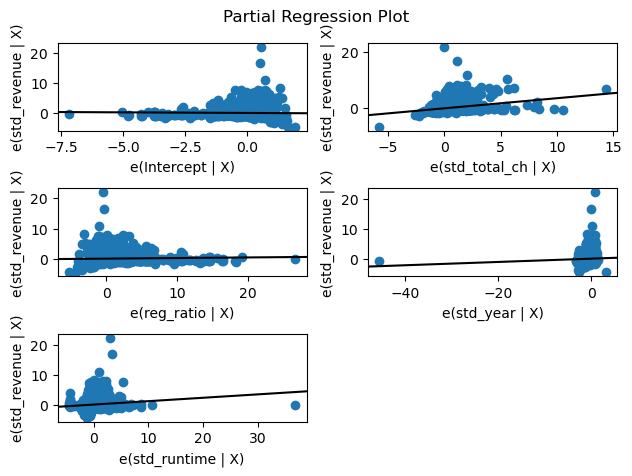

In [47]:
fig = sm.graphics.plot_partregress_grid(result)
fig.tight_layout(pad=1.0)

### Analysis
- Regression show a slightly positive cooeficient of male/female actor ratio on the box office revenue of movies.
- This might be one of the reasons why male characters are more than female characters.

## Analyze the structural gender difference under the social graph of actors ##

In [99]:
# Helper function for plotting the degree distribution of a Graph
def plot_degree_distribution(G):
    degrees = {}
    for node in G.nodes():
        degree = G.degree(node)
        if degree not in degrees:
            degrees[degree] = 0
        degrees[degree] += 1
    sorted_degree = sorted(degrees.items())
    deg = [k for (k,v) in sorted_degree]
    cnt = [v for (k,v) in sorted_degree]
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.ylabel("Frequency")
    plt.xlabel("Degree")

In [100]:
# Helper function for printing various graph properties
def describe_graph(G):
    print(nx.info(G))
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

In [101]:
# Helper function for visualizing the graph
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='g', node_shape=node_shape)
    plt.axis('off')

In [102]:
characters = pd.read_csv(
    characters_path, sep="\t", header=None, names=characters_column_names
)

df_actor_name = characters.dropna(subset = ['actor_name', 'actor_gender'])
df_actor_name.head(10)

wikipedia_id freebase_id release_date              character_name  \
0        975900   /m/03vyhn   2001-08-24                    Akooshay   
1        975900   /m/03vyhn   2001-08-24  Lieutenant Melanie Ballard   
2        975900   /m/03vyhn   2001-08-24         Desolation Williams   
3        975900   /m/03vyhn   2001-08-24          Sgt Jericho Butler   
4        975900   /m/03vyhn   2001-08-24             Bashira Kincaid   
5        975900   /m/03vyhn   2001-08-24   Commander Helena Braddock   
6        975900   /m/03vyhn   2001-08-24                    Whitlock   
7        975900   /m/03vyhn   2001-08-24              Big Daddy Mars   
8        975900   /m/03vyhn   2001-08-24            Michael Descanso   
9        975900   /m/03vyhn   2001-08-24                         Uno   

    actor_dob actor_gender  actor_height actor_ethnicity          actor_name  \
0  1958-08-26            F         1.620             NaN      Wanda De Jesus   
1  1974-08-15            F         1.780      /m/044038p  Natasha Henstridge   
2  1969-06-15            M         1.727         /m/0x67            Ice Cube   
3  1967-09-12            M         1.750             NaN       Jason Statham   
4  1977-09-25            F         1.650             NaN         Clea DuVall   
5  1949-05-26            F         1.727         /m/0x67           Pam Grier   
6  1945-08-02            F         1.753             NaN      Joanna Cassidy   
7         NaN            M           NaN             NaN     Richard Cetrone   
8  1971-03-20            M         1.892             NaN          Liam Waite   
9         NaN            M           NaN             NaN         Duane Davis   

   actor_age freebase_character_map freebase_character_id freebase_actor_id  
0       42.0             /m/0bgchxw            /m/0bgcj3x        /m/03wcfv7  
1       27.0              /m/0jys3m            /m/0bgchn4         /m/0346l4  
2       32.0              /m/0jys3g            /m/0bgchn_        /m/01vw26l  
3       33.0             /m/02vchl6            /m/0bgchnq         /m/034hyc  
4       23.0             /m/02vbb3r            /m/0bgchp9         /m/01y9xg  
5       52.0             /m/02vdcfp            /m/0bgchnd         /m/0418ft  
6       56.0             /m/02vd6kw            /m/0bgchmx         /m/06lj1m  
7        NaN             /m/0bgchsy            /m/0bgcht0        /m/0bgcht7  
8       30.0             /m/03jqhb0            /m/0bgchs4         /m/0ks8b0  
9        NaN             /m/0bgchtj            /m/0bgchtm        /m/03nrwdy

In [103]:
df_actor_name.isna().sum()

wikipedia_id                   0
freebase_id                    0
release_date                9846
character_name            219588
actor_dob                  62635
actor_gender                   0
actor_height              250385
actor_ethnicity           299037
actor_name                     0
actor_age                 114290
freebase_character_map         0
freebase_character_id     219580
freebase_actor_id              0
dtype: int64

In [104]:
df_actor_name_id = df_actor_name.drop_duplicates(subset=['freebase_actor_id'])
df_actor_name_id.set_index('freebase_actor_id', inplace = True)
df_actor_name_id.head()

wikipedia_id freebase_id release_date  \
freebase_actor_id                                          
/m/03wcfv7               975900   /m/03vyhn   2001-08-24   
/m/0346l4                975900   /m/03vyhn   2001-08-24   
/m/01vw26l               975900   /m/03vyhn   2001-08-24   
/m/034hyc                975900   /m/03vyhn   2001-08-24   
/m/01y9xg                975900   /m/03vyhn   2001-08-24   

                               character_name   actor_dob actor_gender  \
freebase_actor_id                                                        
/m/03wcfv7                           Akooshay  1958-08-26            F   
/m/0346l4          Lieutenant Melanie Ballard  1974-08-15            F   
/m/01vw26l                Desolation Williams  1969-06-15            M   
/m/034hyc                  Sgt Jericho Butler  1967-09-12            M   
/m/01y9xg                     Bashira Kincaid  1977-09-25            F   

                   actor_height actor_ethnicity          actor_name  \
freebase_actor_id                                                     
/m/03wcfv7                1.620             NaN      Wanda De Jesus   
/m/0346l4                 1.780      /m/044038p  Natasha Henstridge   
/m/01vw26l                1.727         /m/0x67            Ice Cube   
/m/034hyc                 1.750             NaN       Jason Statham   
/m/01y9xg                 1.650             NaN         Clea DuVall   

                   actor_age freebase_character_map freebase_character_id  
freebase_actor_id                                                          
/m/03wcfv7              42.0             /m/0bgchxw            /m/0bgcj3x  
/m/0346l4               27.0              /m/0jys3m            /m/0bgchn4  
/m/01vw26l              32.0              /m/0jys3g            /m/0bgchn_  
/m/034hyc               33.0             /m/02vchl6            /m/0bgchnq  
/m/01y9xg               23.0             /m/02vbb3r            /m/0bgchp9

In [105]:
# make a dict to contain the actor freebase IDs under the same movie
dict_movies = {}
for index, row in df_actor_name.iterrows():
    if row['wikipedia_id'] not in dict_movies.keys():
        dict_movies[row['wikipedia_id']] = [row['freebase_actor_id']]
    else:
        dict_movies[row['wikipedia_id']].append(row['freebase_actor_id'])

In [106]:
# delete the repeated actor freebase IDs and use the number symbol to replace in order to change it to the nodes on the graph
df_nodes = df_actor_name.freebase_actor_id[df_actor_name.freebase_actor_id.duplicated() == False]

dict_id = {}  # exchange between actor freebase IDs and number symbol
df_nodes_list = list(df_nodes)
for i in range(len(df_nodes_list)):
    dict_id[df_nodes_list[i]] = i
    
df_nodes_id = df_nodes.apply(lambda x: dict_id[x]+1)
df_nodes_id[:10]

0     1
1     2
2     3
3     4
4     5
5     6
6     7
7     8
8     9
9    10
Name: freebase_actor_id, dtype: int64

In [107]:
# find out all partnership between actors and use the number symbol to replace in order to change it to the edges on the graph
source = []
target = []
attribute = []
for key, value in dict_movies.items():
    value_edges = list(itertools.combinations(value, 2))
    for i in range(len(value_edges)):
        source.append(dict_id[value_edges[i][0]]+1)
        target.append(dict_id[value_edges[i][1]]+1)
        attribute.append(key)

##### Graph creation

Now we start to build up the graph with the prepared nodes and edges data. We use `nx.Graph()` to generate an empty undirected graph and load our prepared data. In our social network graph, every actor represents a node and there is a edge between two nodes if the two actors have cooperated at least one movies. The more degrees the node has, the more influential the actor is. First we will analyze the **Top100** most influential actors' gender and height difference preliminarily, and then draw out their social relationship topology. **In the next stage**, we will do some deeper analysis from the structure of social realtionship topology.

In [108]:
# generate a graph
G = nx.Graph()
# load the nodes data
nodes_id = list(df_nodes_id)
G.add_nodes_from(nodes_id)

print(nodes_id[:10])
print(len(G.nodes))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
97379


In [109]:
# load the edges data
count1 = []
count2 = 0
for i in range(len(source)):
    if source[i] > target[i]:
        c = source[i]
        source[i] = target[i]
        target[i] = c
    if source[i] == target[i]:
        count1.append(i)
        count2 += 1

In [110]:
# add the weight and movie ID attributes to the edges
for i in range(len(source)):
    weight = 1
    if source[i] != target[i]:
        G.add_edge(source[i], target[i])
        if 'weight' not in G.edges[source[i], target[i]].keys():
            G.edges[source[i], target[i]]['weight'] = weight
            G.edges[source[i], target[i]]['wikipedia_id'] = [attribute[i]]
        else:
            G.edges[source[i], target[i]]['weight'] += 1
            G.edges[source[i], target[i]]['wikipedia_id'].append(attribute[i]) 

In [111]:
# There is no attributes in the nodes now
G.nodes[1]

{}

In [112]:
print(nx.info(G))

Graph with 97379 nodes and 1718283 edges


In [113]:
describe_graph(G)

Graph with 97379 nodes and 1718283 edges
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0004
Global clustering coefficient aka Transitivity: 0.1327


In [114]:
# connected components
comp = list(nx.connected_components(G))
print('The graph contains', len(comp), 'connected components')

The graph contains 1595 connected components


In [115]:
largest_comp = max(comp, key=len)
percentage_lcc = len(largest_comp)/G.number_of_nodes() * 100
print('The largest component has', len(largest_comp), 'nodes', 'accounting for %.2f'% percentage_lcc, '% of the nodes') 

The largest component has 91876 nodes accounting for 94.35 % of the nodes


In [116]:
# add the gender feature to the nodes in graph
gender_dict = {}
error_number = []
for key, value in dict_id.items():
    try:
        gender_dict[value+1] = df_actor_name_id.loc[key].actor_gender
    except:
        error_number.append(value+1)
nx.set_node_attributes(G, gender_dict, 'gender' )

In [117]:
G.nodes[1]

{'gender': 'F'}

In [118]:
# for gender attributes
nx.attribute_assortativity_coefficient(G, 'gender')

0.026499667110727498

There is no notion of *gender homophily* in this network, which makes sense due to the **gender imbalance**.

In [119]:
# creat the male subgraph and female subgraph
male = []
female = []
for i in G.nodes():
    if G.nodes[i]['gender'] == 'M':
        male.append(i)
    if G.nodes[i]['gender'] == 'F':
        female.append(i)
G_male = G.subgraph(male)
G_female = G.subgraph(female)

In [120]:
describe_graph(G_male)

Graph with 61517 nodes and 773898 edges
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0004
Global clustering coefficient aka Transitivity: 0.1349


In [121]:
describe_graph(G_female)

Graph with 35862 nodes and 200989 edges
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0003
Global clustering coefficient aka Transitivity: 0.1486


In [122]:
plot_degree_distribution(G_male)

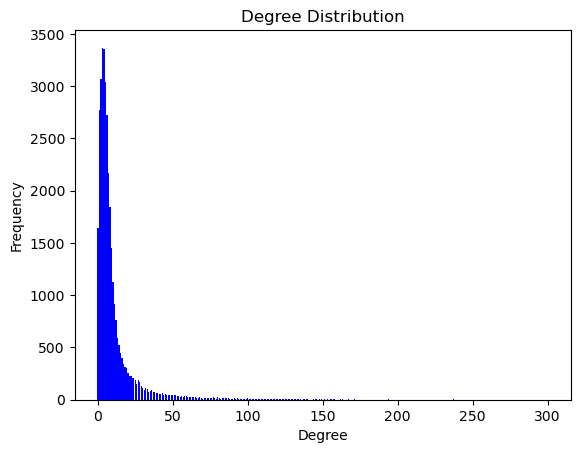

In [123]:
plot_degree_distribution(G_female)

In [124]:
# Sort the actors with the degree of nodes and print the top10 
dict_degree = dict(G.degree())
result = sorted(dict_degree.items(), key = lambda x: x[1], reverse = True)
result100 = [i[0]-1 for i in result[:100]]

print('The first is the number symbol of actors and the second is its corresponding degree')
result[:10]

The first is the number symbol of actors and the second is its corresponding degree


[(5368, 1157),
 (1347, 1056),
 (1963, 1012),
 (3492, 1007),
 (2787, 989),
 (3051, 975),
 (4607, 955),
 (887, 945),
 (429, 940),
 (5762, 929)]

In [125]:
# Helper function for using number symbol to find the corresponding actor name
def find_actor_name_by_number(n):
    query = list(dict_id.keys())[n-1]
    actor_name = df_actor_name_id.loc[query].actor_name
    return actor_name

In [126]:
# an example two famous actors
print(find_actor_name_by_number(1347))
print(find_actor_name_by_number(5368))
print(find_actor_name_by_number(2105))

Christopher Lee
Samuel L. Jackson
Whoopi Goldberg


In [127]:
# generate a new Top 100
G100 = G.subgraph([i[0] for i in result[:100]])

In [128]:
subgraph_male = G.subgraph([5368]+list(G100.neighbors(5368)))
subgraph_female = G.subgraph([2105]+list(G100.neighbors(2105)))

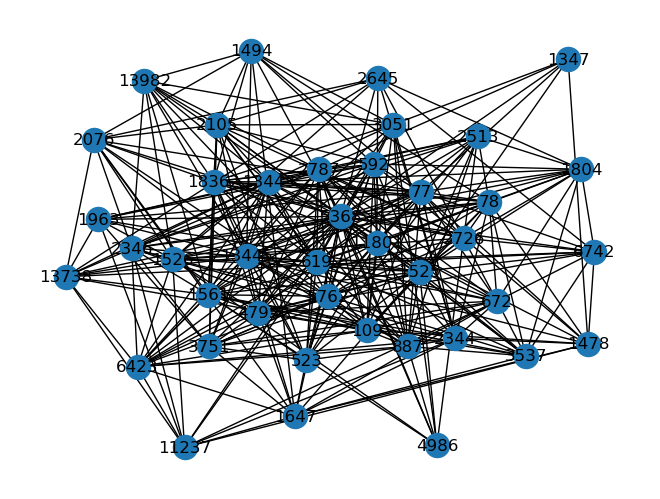

In [129]:
# draw out the subgraph with most famous male actor Samuel L. Jackson (5368)
nx.draw_spring(subgraph_male, with_labels=True)

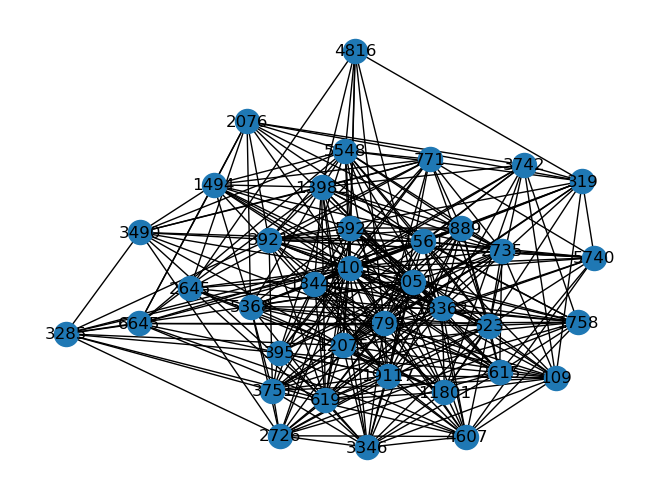

In [130]:
# draw out the subgraph with most famous female actor Whoopi Goldberg (2105)
nx.draw_spring(subgraph_female, with_labels=True)

In [131]:
print(nx.clustering(G, [5368, 2105]))

{5368: 0.038923597300021234, 2105: 0.05126912763855567}


In [132]:
print(nx.clustering(G100, [5368, 2105]))

{5368: 0.38461538461538464, 2105: 0.4365079365079365}


##### Analysis

It is interesting that although male actors's nodes have more average degrees in male subgraph, which means that there are more cooperations in the film and television industry between male actors, female actors actually have more stable partnerships with female actors accroding to the higher transitivity value of gender subgraphs and higher clustering coefficient of specific actors.

One convincing explanation is that the number of female actors is less than the male actors, so for every specific kind of female character in the movies, there are few potiental female candidates, and that is why there is more stable cooperation relationship between female actors.

In [133]:
# use louvain algorithm to detect the groups
partition = community_louvain.best_partition(G100, weight = 'weight')
# add it as an attribute to the nodes
for n in G100.nodes:
    G100.nodes[n]["louvain"] = partition[n]

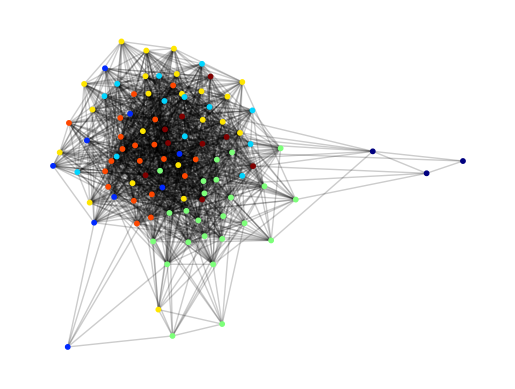

In [134]:
# plot it out
pos = nx.spring_layout(G100,k=0.1)
ec = nx.draw_networkx_edges(G100, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(G100, pos, nodelist=G100.nodes(), node_color=[G100.nodes[n]["louvain"] for n in G100.nodes], 
                            node_size=10, cmap=plt.cm.jet)
plt.axis('off')
plt.show()

In [135]:
female = 0
female_height = []
female_set = []
male = 0
male_height = []
male_set = []
error = []
for i in result100:
    query = df_nodes_list[i]
    gender = df_actor_name_id.loc[query].actor_gender
    if gender == 'F':
        female += 1
        female_set.append(i)
        female_height.append(df_actor_name_id.loc[query].actor_height)
    elif gender == 'M':
        male += 1
        male_set.append(i)
        male_height.append(df_actor_name_id.loc[query].actor_height)
    else:
        error.append(df_actor_name_id.loc[query].actor_name)
print('The number of female and male in Top100 ranking are {} and {}'.format(female, male))
print('The number of gender missing value in Top100 result is {}'.format(len(error)))

The number of female and male in Top100 ranking are 8 and 92
The number of gender missing value in Top100 result is 0


In [136]:
# the female names in Top100 actors
female_set

[18361, 2104, 1727, 3920, 8217, 3741, 1525, 2841]

Text(0, 0.5, 'population')

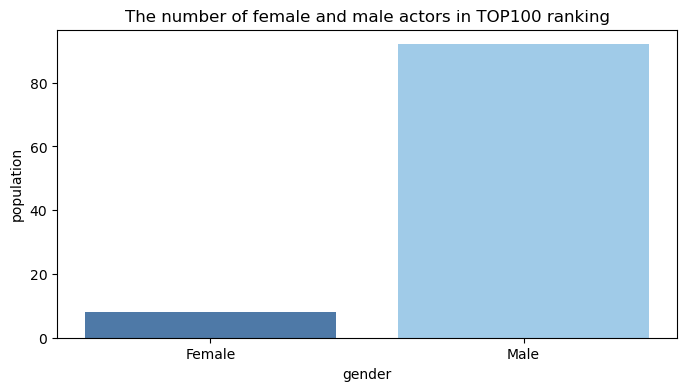

In [137]:
# plot the histogram
plt.figure(figsize = (8,4))
data = [female, male]
labels = ['Female', 'Male']
colors = ["#4E79A7",  "#A0CBE8"]
plt.bar(range(len(data)), data, tick_label = labels, color = colors)
plt.title('The number of female and male actors in TOP100 ranking')
plt.xlabel('gender')
plt.ylabel('population')

It is a surprise that there are only eight females in the Top100 actors, which shows that in social network of actors the male actors occupy the absolute main force.

In [138]:
all_male_height = []
all_female_height = []
for index, row in df_actor_name_id.iterrows():
    if row.actor_gender == 'M':
        all_male_height.append(row.actor_height)
    if row.actor_gender == 'F':
        all_female_height.append(row.actor_height) 

Because maybe there are some extreme values in actor height values, we need to correct the original data.

In [139]:
all_male_height_correct = [ i for i in all_male_height if i <= 2.5]
all_female_height_correct = [i for i in all_female_height if i <= 2.5]
male_height_correct = [i for i in male_height if i <= 2.5 ]
female_height_correct = [i for i in female_height if i <= 2.5 ]

In [140]:
male_height_average = np.nanmean(male_height_correct)
female_height_average = np.nanmean(female_height_correct)
all_male_height_average = np.nanmean(all_male_height_correct)
all_female_height_average = np.nanmean(all_female_height_correct)

print('The average height of female and male in all database are {}m and {}m'.format(all_female_height_average, all_male_height_average))
print('The average height of female and male in Top100 ranking are {}m and {}m'.format(female_height_average, male_height_average))

The average height of female and male in all database are 1.6584129269137515m and 1.8008808562428409m
The average height of female and male in Top100 ranking are 1.7075m and 1.7955384615384615m


Text(0, 0.5, 'Average Meter')

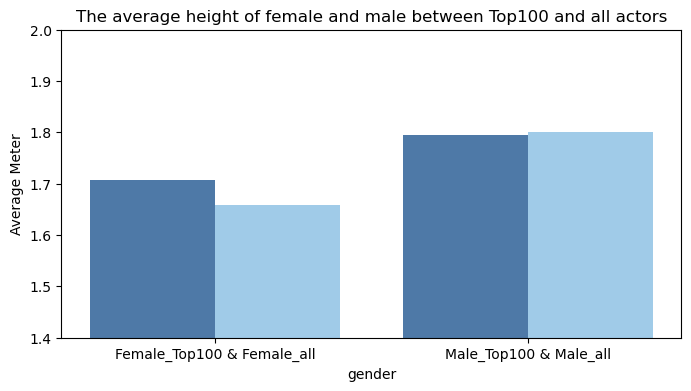

In [141]:
y1 = [female_height_average, male_height_average]
y2 = [all_female_height_average, all_male_height_average]
x = np.arange(len(y1))
width = 0.4
color1 = ["#4E79A7"]
color2 = ["#A0CBE8"]
plt.figure(figsize=(8,4))
plt.ylim(1.40, 2.00)
plt.bar(x=x, height=y1, width=width, color=color1)
plt.bar(x=x+width, height=y2, width=width, color=color2)
plt.title('The average height of female and male between Top100 and all actors')
plt.xticks(x+width/2, ['Female_Top100 & Female_all', 'Male_Top100 & Male_all'])
plt.xlabel('gender')
plt.ylabel('Average Meter')

Accroding to the above result, we find that the average height of male between Top100 and all actors seems to be very similar, so we do an additional T-test for it.

In [142]:
print(stats.ttest_ind(all_female_height_correct, female_height_correct))
print(stats.ttest_ind(all_male_height_correct, male_height_correct))

Ttest_indResult(statistic=-1.789147544311883, pvalue=0.07364340046714411)
Ttest_indResult(statistic=0.5049640885114878, pvalue=0.613599791610447)


The p-value of T-test is **0.61**, which shows that they are different in fact. So we can find that for female actors, who are in Top100 are usualy taller, but for male actors, who are in Top100 almost the same as the average or even shorter than average. It is a fact that taller people are more likely to become an actor or appear in the movies. Furtherly we can make a conclusion that Society has broad height requirements for male actors, but it often has higher requirements for women.